In [1]:
from z3 import *
import numpy as np
from csv import writer
import matplotlib.pyplot as plt
import time

In [2]:
# instance = [[6, 7, 135], [0, 4, 152], [0, 13, 150], 
#             [7, 10, 178], [0, 9, 33], [8, 9, 185], [13, 13, 57], [8, 9, 143], [1, 13, 95], [7, 11, 118]]
instance = [[0,1,35], [0,2,40], [0,1,45], [1, 2, 48]]#, [1,2,38]]
# instance = [[5, 8, 36], [0, 9, 53], [9, 9, 33]]#, [4, 5, 61], [2, 3, 132]]
# instance = [[0, 2, 150], [0, 1, 100], [0, 1, 100], [0, 2, 120]]
# instance = [[1, 3, 73], [8, 8, 131], [6, 8, 99], [0, 1, 71], [2, 6, 149], [6, 9, 190], [2, 8, 100]]

ports = 10
R_fast = 60
R_slow = 20
W_penalty = -1 #Penalty for waiting
D_penalty = -2 #Penalty for denial
sp_fast = 1.31 # selling price for fast charging
sp_slow = 1.31 # selling price for slow charging
# energy_demand = [j[2] for j in instance]

# variables 'alpha', 'beta' for calculating customer satisfaction:
alpha = 1
beta = 1

# variables for calculating Revenue
# Actions
F = R_fast #Fast charging
S = R_slow #Slow charging
W = W_penalty #Wait
D = D_penalty #Deny

HEIGHT = len(instance)
WIDTH = list(map(max, zip(*instance)))[1] + 1

X =[[ Int('k%d_t%d' % (k,t))
         for t in range (  WIDTH )] for k in range ( HEIGHT )] #instance[k][0], instance[k][1]+1
print(X)


[[k0_t0, k0_t1, k0_t2], [k1_t0, k1_t1, k1_t2], [k2_t0, k2_t1, k2_t2], [k3_t0, k3_t1, k3_t2]]


In [3]:
def pricing_Model(E):
#     return E/10
#     return 2.0
    gridPrice = (E*E)/1000
    return gridPrice

def expectedSlots(c1, c2):
    
    a = np.array([[R_fast,R_slow], [1, 1]])
    b = np.array([c1, c2])
    x = np.linalg.solve(a, b)
    return x

In [4]:
# Calculate R and CS from this table
def calculate_Revenue(Allocation_table):
#     print("Original:",Allocation_table)
#     Transpose of Allocation table
    Allocation_table = np.transpose(Allocation_table)
#     print("After transpose",Allocation_table)

    gridPriceTable = []
    
    Total_revenue = 0
    
    for t in Allocation_table: #'t' time slot
        
        [count_F] = np.where(t == F) #Fast charging
#         print("count of 2:",count)
        count_F = len(count_F)
        E = count_F * R_fast        
        [count_S] = np.where(t == S) #Slow charging
#         print("count of 1:",count)
        count_S = len(count_S)
        E = E + count_S * R_slow
        
        gridPrice = pricing_Model(E)
        
        slow_charger_price = sp_slow * gridPrice
        fast_charger_price = sp_fast * gridPrice
        profit = (fast_charger_price - gridPrice)*count_F + (slow_charger_price - gridPrice)*count_S
        
#         print("\nslow_charger_price:", slow_charger_price)
        
        [count] = np.where(t == W) #Waiting
        count = len(count)
        total_W_penalty = count * W_penalty
#         print("Total W penalty:",total_W_penalty)
        profit = profit + total_W_penalty
        
        [count] = np.where(t == D) #Denied
        count = len(count)
        total_D_penalty = count * D_penalty
#         print("Total D penalty:",total_D_penalty)
        profit = profit + total_D_penalty
        
        Total_revenue = Total_revenue + profit
        
        gridPriceTable.append(gridPrice)
#         print("\n grid Price:", gridPrice)
    gridPriceTable = np.array(gridPriceTable)
    
    print("Revenue:",Total_revenue)
    
    return gridPriceTable, Total_revenue

In [5]:
def calculate_CustomerSatisfaction(Allocation_table, EV_info, gridPriceTable):
#     print("Calculating Customer Satisfaction...")
#     print("grid price table",gridPriceTable)
    total_CustomerSatisfaction = 0
    
    for cust in range(len(Allocation_table)):
        E_charged = 0
        
#         Calculate the first product
        total_allowedTime = EV_info[cust][1] - EV_info[cust][0] + 1
#         print(" ",total_allowedTime)
        [count] = np.where((Allocation_table[cust] == F) | (Allocation_table[cust] == S) 
                           | (Allocation_table[cust] == W))
        count = len(count)
#         print(" Charged for:",count)
        total_chargedTime = count
        term_1 = 1 - total_chargedTime/total_allowedTime
#         print(" First product:", term_1)
        
#         Calculate the second product
        [count] = np.where(Allocation_table[cust] == F)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * R_fast
        [count] = np.where(Allocation_table[cust] == S)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * R_slow
        E_demand = EV_info[cust][2]
        if E_charged>E_demand:
            E_charged = E_demand
        
#         print("Total E charged:",E_charged)
        term_2 = E_charged/E_demand
#         print("second product:",term_2)
#         print("term_1 * term_2:", term_1 * term_2)

#         -----------------------------------------
        c1 = E_demand
        c2 = total_allowedTime
        
        expectedAllocation = expectedSlots(c1, c2)
        f = expectedAllocation[0] # No. of expected fast chargers
        s = expectedAllocation[1] # No. of expected slow chargers
        t_Arrival = EV_info[cust][0]
        gridPrice_atArrival = gridPriceTable[t_Arrival]
        
        expectedSellingPrice = (f * sp_fast + s * sp_slow) * gridPrice_atArrival
#         print("\nexpected selling price", expectedSellingPrice)
        
        actualSellingPrice = 0
        
        for t in range(len(gridPriceTable)):
            if (Allocation_table[cust][t] == F):
                actualSellingPrice = actualSellingPrice + sp_fast * gridPriceTable[t]
            elif (Allocation_table[cust][t] == S):
                actualSellingPrice = actualSellingPrice + sp_slow * gridPriceTable[t]

#         print("actual selling price", actualSellingPrice)
        Pa_by_Pe = (actualSellingPrice)/(expectedSellingPrice + 0.0000001)
#         print("cust:",cust," Pa_by_Pe: ",Pa_by_Pe)
        
        term_3 = alpha * Pa_by_Pe + beta
#         print("product 3:", term_3)
#         -----------------------------------------

        indiv_customerSatisfation = term_1 * term_2 / term_3
#         print("indiv CS:",indiv_customerSatisfation)
        
        total_CustomerSatisfaction = total_CustomerSatisfaction + indiv_customerSatisfation
    print("total CS:",total_CustomerSatisfaction)
#     print("term 1:", term_1)
#     print("term 2:", term_2)
#     print("term 3:", 1/term_3)
#     print("term 1 * term 2:", term_1*term_2)
    return(total_CustomerSatisfaction, term_1, term_2, 1/term_3, expectedSellingPrice, actualSellingPrice)

In [6]:
def plot_graph(fileName):

    # Plotting
    w = 4
    h = 3
    d = 170
    plt.figure(figsize=(w, h), dpi=d)
    
    data_Z3 = np.genfromtxt(
        fileName+".csv", names=True,
        dtype="float", delimiter=",")

    smt = plt.plot(data_Z3["Revenue"], data_Z3["CS"], ".",markersize=4, color = "blue",label='SMT')
    
#     data_nsga = np.genfromtxt(
#         "nsga2_9.csv", names=True,
#         dtype="float", delimiter=",")

#     nsga2 = plt.plot(data_nsga["Revenue"], data_nsga["CS"], '+',markersize=4, color = "yellow",label='nsga2')
    
#     data_h = np.genfromtxt(
#         "heuristic_9.csv", names=True,
#         dtype="float", delimiter=",")

#     heuristic = plt.plot(data_h["Revenue"], data_h["CS"], "x",markersize=3, color = "red",label='heuristic')
    
    plt.xlabel('Revenue')
    plt.ylabel('Customer Satisfaction')
    plt.legend(fontsize=6)
    plt.savefig(fileName + ".png")

In [7]:
def write_to_file(results, fileName):
    #     field names  
    fields = ['Revenue', 'CS', 'Time', 'Energy', 'Price', 'PE']

    #     name of csv file  
    filename = fileName
    #     writing to csv file  
    with open(filename, 'w') as csvfile: 

    #         creating a csv writer object  
        csvwriter = writer(csvfile)

    #         writing the fields  
        csvwriter.writerow(fields)
        count_Revenue = 0
        count_CS = 0
        revenues_list_temp = []
        cs_list_temp = []
        
        for i, r in enumerate(results):
            print("\n",i+1)
            Allocation_table = np.full((HEIGHT, WIDTH), 0, dtype=int)
        #     print(Allocation_table)
#             print("\n")
            count = 0
#             print("r:",r,"len(r):",len(r))
            
            for j in r:
                if count<(len(r)-1):
                    v = str(j)
                    pos=v.find("_", 0, len(v))
#                     print(v, pos)

                    k = int(v[1:pos])
                    t = int(v[pos+2:])

                    op = r[j].as_long()
#                     print("k:",k,"t:",t,"op:", op)

                    Allocation_table[k,t] = op
                count += 1

            print(Allocation_table)
            gridPriceTable, revenue = calculate_Revenue(Allocation_table)
#             print("Revenue:", revenue)

            customer_satisfaction, term1, term2, term3, PE, PA = calculate_CustomerSatisfaction(Allocation_table, 
                                                                   instance, gridPriceTable)
#             print("\t rho_T:", term1)
#             print("\t rho_E:", term2)
#             print("\t rho_T*rho_E:", term1*term2)
#             print("\t rho_P:", term3)
#             print("\t PE:", PE)
#             print("\t PA:", PA)
#             print("\t rhoP:", term3)
#             print("Customer satisfaction:", customer_satisfaction)
            revenues_list_temp.append(revenue)
            cs_list_temp.append(customer_satisfaction)
            
#             print("Revenue + Customer Satisfaction:", revenue+customer_satisfaction)

            rows=[[revenue, customer_satisfaction, term1, term2, term3, PE]] 

        #         writing the data rows  
            csvwriter.writerows(rows)
#         print("All revenues",revenues_list_temp, "\nAll CSs",cs_list_temp)
        print("\nmax Revenue:",max(revenues_list_temp),"\nmax CS:",max(cs_list_temp))
        print("\nmax Revenue pos:",revenues_list_temp.index(max(revenues_list_temp))+1)
        print("\nmax CS pos:",cs_list_temp.index(max(cs_list_temp))+1)
    

In [8]:
# Return the first "M" models of formula list of formulas F 
def get_models():
    result = []
    i = 0
    while s.check() == sat:
#         print("Testing")
        i += 1
        print("i=",i)
        m = s.model()
        result.append(m)
        # Create a new constraint the blocks the current model
        block = []
        m1 = [m[i] for i in range(len(m)-1)]
        for d in m1:
#                 d is a declaration
            if d.arity() > 0:
                raise Z3Exception("Incorrect number of arguments")
            # create a constant from declaration
            c = d()
#             print("testing:",c)
            if is_array(c) or c.sort().kind() == Z3_UNINTERPRETED_SORT:
                raise Z3Exception("arrays and uninterpreted sorts are not supported")
            block.append(c != m[d])
        s.add(Or(block))
    return result

In [9]:
def Z3_GridPrice(Load):
    
    return ToReal(Load*Load)/float(1000)

In [10]:
# Pick at least one from the 4 options
def pickReward(p):
    return Or([p==r for r in Rewards])

EV input: [[0, 1, 35], [0, 2, 40], [0, 1, 45], [1, 2, 48]]
No. of EVs: 4 
No. of time slots: 3 
Ports: 10
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100
i= 101
i= 102
i= 103
i= 104
i= 105
i= 106
i= 107
i= 108
i= 109
i= 110
i= 111
i= 112
i= 113
i= 114
i= 115
i= 116
i= 117
i= 118
i= 119
i= 120
i= 121
i= 122
i= 123
i= 124
i= 125
i= 126
i= 127
i= 128
i= 129
i= 130
i= 131
i= 132
i= 133
i= 134
i= 135
i= 136
i= 137
i= 138
i= 139
i= 140
i= 141
i= 142
i= 143
i

i= 1154
i= 1155
i= 1156
i= 1157
i= 1158
i= 1159
i= 1160
i= 1161
i= 1162
i= 1163
i= 1164
i= 1165
i= 1166
i= 1167
i= 1168
i= 1169
i= 1170
i= 1171
i= 1172
i= 1173
i= 1174
i= 1175
i= 1176
i= 1177
i= 1178
i= 1179
i= 1180
i= 1181
i= 1182
i= 1183
i= 1184
i= 1185
i= 1186
i= 1187
i= 1188
i= 1189
i= 1190
i= 1191
i= 1192
i= 1193
i= 1194
i= 1195
i= 1196
i= 1197
i= 1198
i= 1199
i= 1200
i= 1201
i= 1202
i= 1203
i= 1204
i= 1205
i= 1206
i= 1207
i= 1208
i= 1209
i= 1210
i= 1211
i= 1212
i= 1213
i= 1214
i= 1215
i= 1216
i= 1217
i= 1218
i= 1219
i= 1220
i= 1221
i= 1222
i= 1223
i= 1224
i= 1225
i= 1226
i= 1227
i= 1228
i= 1229
i= 1230
i= 1231
i= 1232
i= 1233
i= 1234
i= 1235
i= 1236
i= 1237
i= 1238
i= 1239
i= 1240
i= 1241
i= 1242
i= 1243
i= 1244
i= 1245
i= 1246
i= 1247
i= 1248
i= 1249
i= 1250
i= 1251
i= 1252
i= 1253
i= 1254
i= 1255
i= 1256
i= 1257
i= 1258
i= 1259
i= 1260
i= 1261
i= 1262
i= 1263
i= 1264
i= 1265
i= 1266
i= 1267
i= 1268
i= 1269
i= 1270
i= 1271
i= 1272
i= 1273
i= 1274
i= 1275
i= 1276
i= 1277
i= 1278


i= 2200
i= 2201
i= 2202
i= 2203
i= 2204
i= 2205
i= 2206
i= 2207
i= 2208
i= 2209
i= 2210
i= 2211
i= 2212
i= 2213
i= 2214
i= 2215
i= 2216
i= 2217
i= 2218
i= 2219
i= 2220
i= 2221
i= 2222
i= 2223
i= 2224
i= 2225
i= 2226
i= 2227
i= 2228
i= 2229
i= 2230
i= 2231
i= 2232
i= 2233
i= 2234
i= 2235
i= 2236
i= 2237
i= 2238
i= 2239
i= 2240
i= 2241
i= 2242
i= 2243
i= 2244
i= 2245
i= 2246
i= 2247
i= 2248
i= 2249
i= 2250
i= 2251
i= 2252
i= 2253
i= 2254
i= 2255
i= 2256
i= 2257
i= 2258
i= 2259
i= 2260
i= 2261
i= 2262
i= 2263
i= 2264
i= 2265
i= 2266
i= 2267
i= 2268
i= 2269
i= 2270
i= 2271
i= 2272
i= 2273
i= 2274
i= 2275
i= 2276
i= 2277
i= 2278
i= 2279
i= 2280
i= 2281
i= 2282
i= 2283
i= 2284
i= 2285
i= 2286
i= 2287
i= 2288
i= 2289
i= 2290
i= 2291
i= 2292
i= 2293
i= 2294
i= 2295
i= 2296
i= 2297
i= 2298
i= 2299
i= 2300
i= 2301
i= 2302
i= 2303
i= 2304
i= 2305
i= 2306
i= 2307
i= 2308
i= 2309
i= 2310
i= 2311
i= 2312
i= 2313
i= 2314
i= 2315
i= 2316
i= 2317
i= 2318
i= 2319
i= 2320
i= 2321
i= 2322
i= 2323
i= 2324


i= 3258
i= 3259
i= 3260
i= 3261
i= 3262
i= 3263
i= 3264
i= 3265
i= 3266
i= 3267
i= 3268
i= 3269
i= 3270
i= 3271
i= 3272
i= 3273
i= 3274
i= 3275
i= 3276
i= 3277
i= 3278
i= 3279
i= 3280
i= 3281
i= 3282
i= 3283
i= 3284
i= 3285
i= 3286
i= 3287
i= 3288
i= 3289
i= 3290
i= 3291
i= 3292
i= 3293
i= 3294
i= 3295
i= 3296
i= 3297
i= 3298
i= 3299
i= 3300
i= 3301
i= 3302
i= 3303
i= 3304
i= 3305
i= 3306
i= 3307
i= 3308
i= 3309
i= 3310
i= 3311
i= 3312
i= 3313
i= 3314
i= 3315
i= 3316
i= 3317
i= 3318
i= 3319
i= 3320
i= 3321
i= 3322
i= 3323
i= 3324
i= 3325
i= 3326
i= 3327
i= 3328
i= 3329
i= 3330
i= 3331
i= 3332
i= 3333
i= 3334
i= 3335
i= 3336
i= 3337
i= 3338
i= 3339
i= 3340
i= 3341
i= 3342
i= 3343
i= 3344
i= 3345
i= 3346
i= 3347
i= 3348
i= 3349
i= 3350
i= 3351
i= 3352
i= 3353
i= 3354
i= 3355
i= 3356
i= 3357
i= 3358
i= 3359
i= 3360
i= 3361
i= 3362
i= 3363
i= 3364
i= 3365
i= 3366
i= 3367
i= 3368
i= 3369
i= 3370
i= 3371
i= 3372
i= 3373
i= 3374
i= 3375
i= 3376
i= 3377
i= 3378
i= 3379
i= 3380
i= 3381
i= 3382


i= 4311
i= 4312
i= 4313
i= 4314
i= 4315
i= 4316
i= 4317
i= 4318
i= 4319
i= 4320
i= 4321
i= 4322
i= 4323
i= 4324
i= 4325
i= 4326
i= 4327
i= 4328
i= 4329
i= 4330
i= 4331
i= 4332
i= 4333
i= 4334
i= 4335
i= 4336
i= 4337
i= 4338
i= 4339
i= 4340
i= 4341
i= 4342
i= 4343
i= 4344
i= 4345
i= 4346
i= 4347
i= 4348
i= 4349
i= 4350
i= 4351
i= 4352
i= 4353
i= 4354
i= 4355
i= 4356
i= 4357
i= 4358
i= 4359
i= 4360
i= 4361
i= 4362
i= 4363
i= 4364
i= 4365
i= 4366
i= 4367
i= 4368
i= 4369
i= 4370
i= 4371
i= 4372
i= 4373
i= 4374
i= 4375
i= 4376
i= 4377
i= 4378
i= 4379
i= 4380
i= 4381
i= 4382
i= 4383
i= 4384
i= 4385
i= 4386
i= 4387
i= 4388
i= 4389
i= 4390
i= 4391
i= 4392
i= 4393
i= 4394
i= 4395
i= 4396
i= 4397
i= 4398
i= 4399
i= 4400
i= 4401
i= 4402
i= 4403
i= 4404
i= 4405
i= 4406
i= 4407
i= 4408
i= 4409
i= 4410
i= 4411
i= 4412
i= 4413
i= 4414
i= 4415
i= 4416
i= 4417
i= 4418
i= 4419
i= 4420
i= 4421
i= 4422
i= 4423
i= 4424
i= 4425
i= 4426
i= 4427
i= 4428
i= 4429
i= 4430
i= 4431
i= 4432
i= 4433
i= 4434
i= 4435


i= 5347
i= 5348
i= 5349
i= 5350
i= 5351
i= 5352
i= 5353
i= 5354
i= 5355
i= 5356
i= 5357
i= 5358
i= 5359
i= 5360
i= 5361
i= 5362
i= 5363
i= 5364
i= 5365
i= 5366
i= 5367
i= 5368
i= 5369
i= 5370
i= 5371
i= 5372
i= 5373
i= 5374
i= 5375
i= 5376
i= 5377
i= 5378
i= 5379
i= 5380
i= 5381
i= 5382
i= 5383
i= 5384
i= 5385
i= 5386
i= 5387
i= 5388
i= 5389
i= 5390
i= 5391
i= 5392
i= 5393
i= 5394
i= 5395
i= 5396
i= 5397
i= 5398
i= 5399
i= 5400
i= 5401
i= 5402
i= 5403
i= 5404
i= 5405
i= 5406
i= 5407
i= 5408
i= 5409
i= 5410
i= 5411
i= 5412
i= 5413
i= 5414
i= 5415
i= 5416
i= 5417
i= 5418
i= 5419
i= 5420
i= 5421
i= 5422
i= 5423
i= 5424
i= 5425
i= 5426
i= 5427
i= 5428
i= 5429
i= 5430
i= 5431
i= 5432
i= 5433
i= 5434
i= 5435
i= 5436
i= 5437
i= 5438
i= 5439
i= 5440
i= 5441
i= 5442
i= 5443
i= 5444
i= 5445
i= 5446
i= 5447
i= 5448
i= 5449
i= 5450
i= 5451
i= 5452
i= 5453
i= 5454
i= 5455
i= 5456
i= 5457
i= 5458
i= 5459
i= 5460
i= 5461
i= 5462
i= 5463
i= 5464
i= 5465
i= 5466
i= 5467
i= 5468
i= 5469
i= 5470
i= 5471


i= 6390
i= 6391
i= 6392
i= 6393
i= 6394
i= 6395
i= 6396
i= 6397
i= 6398
i= 6399
i= 6400
i= 6401
i= 6402
i= 6403
i= 6404
i= 6405
i= 6406
i= 6407
i= 6408
i= 6409
i= 6410
i= 6411
i= 6412
i= 6413
i= 6414
i= 6415
i= 6416
i= 6417
i= 6418
i= 6419
i= 6420
i= 6421
i= 6422
i= 6423
i= 6424
i= 6425
i= 6426
i= 6427
i= 6428
i= 6429
i= 6430
i= 6431
i= 6432
i= 6433
i= 6434
i= 6435
i= 6436
i= 6437
i= 6438
i= 6439
i= 6440
i= 6441
i= 6442
i= 6443
i= 6444
i= 6445
i= 6446
i= 6447
i= 6448
i= 6449
i= 6450
i= 6451
i= 6452
i= 6453
i= 6454
i= 6455
i= 6456
i= 6457
i= 6458
i= 6459
i= 6460
i= 6461
i= 6462
i= 6463
i= 6464
i= 6465
i= 6466
i= 6467
i= 6468
i= 6469
i= 6470
i= 6471
i= 6472
i= 6473
i= 6474
i= 6475
i= 6476
i= 6477
i= 6478
i= 6479
i= 6480
i= 6481
i= 6482
i= 6483
i= 6484
i= 6485
i= 6486
i= 6487
i= 6488
i= 6489
i= 6490
i= 6491
i= 6492
i= 6493
i= 6494
i= 6495
i= 6496
i= 6497
i= 6498
i= 6499
i= 6500
i= 6501
i= 6502
i= 6503
i= 6504
i= 6505
i= 6506
i= 6507
i= 6508
i= 6509
i= 6510
i= 6511
i= 6512
i= 6513
i= 6514


i= 7438
i= 7439
i= 7440
i= 7441
i= 7442
i= 7443
i= 7444
i= 7445
i= 7446
i= 7447
i= 7448
i= 7449
i= 7450
i= 7451
i= 7452
i= 7453
i= 7454
i= 7455
i= 7456
i= 7457
i= 7458
i= 7459
i= 7460
i= 7461
i= 7462
i= 7463
i= 7464
i= 7465
i= 7466
i= 7467
i= 7468
i= 7469
i= 7470
i= 7471
i= 7472
i= 7473
i= 7474
i= 7475
i= 7476
i= 7477
i= 7478
i= 7479
i= 7480
i= 7481
i= 7482
i= 7483
i= 7484
i= 7485
i= 7486
i= 7487
i= 7488
i= 7489
i= 7490
i= 7491
i= 7492
i= 7493
i= 7494
i= 7495
i= 7496
i= 7497
i= 7498
i= 7499
i= 7500
i= 7501
i= 7502
i= 7503
i= 7504
i= 7505
i= 7506
i= 7507
i= 7508
i= 7509
i= 7510
i= 7511
i= 7512
i= 7513
i= 7514
i= 7515
i= 7516
i= 7517
i= 7518
i= 7519
i= 7520
i= 7521
i= 7522
i= 7523
i= 7524
i= 7525
i= 7526
i= 7527
i= 7528
i= 7529
i= 7530
i= 7531
i= 7532
i= 7533
i= 7534
i= 7535
i= 7536
i= 7537
i= 7538
i= 7539
i= 7540
i= 7541
i= 7542
i= 7543
i= 7544
i= 7545
i= 7546
i= 7547
i= 7548
i= 7549
i= 7550
i= 7551
i= 7552
i= 7553
i= 7554
i= 7555
i= 7556
i= 7557
i= 7558
i= 7559
i= 7560
i= 7561
i= 7562


i= 8465
i= 8466
i= 8467
i= 8468
i= 8469
i= 8470
i= 8471
i= 8472
i= 8473
i= 8474
i= 8475
i= 8476
i= 8477
i= 8478
i= 8479
i= 8480
i= 8481
i= 8482
i= 8483
i= 8484
i= 8485
i= 8486
i= 8487
i= 8488
i= 8489
i= 8490
i= 8491
i= 8492
i= 8493
i= 8494
i= 8495
i= 8496
i= 8497
i= 8498
i= 8499
i= 8500
i= 8501
i= 8502
i= 8503
i= 8504
i= 8505
i= 8506
i= 8507
i= 8508
i= 8509
i= 8510
i= 8511
i= 8512
i= 8513
i= 8514
i= 8515
i= 8516
i= 8517
i= 8518
i= 8519
i= 8520
i= 8521
i= 8522
i= 8523
i= 8524
i= 8525
i= 8526
i= 8527
i= 8528
i= 8529
i= 8530
i= 8531
i= 8532
i= 8533
i= 8534
i= 8535
i= 8536
i= 8537
i= 8538
i= 8539
i= 8540
i= 8541
i= 8542
i= 8543
i= 8544
i= 8545
i= 8546
i= 8547
i= 8548
i= 8549
i= 8550
i= 8551
i= 8552
i= 8553
i= 8554
i= 8555
i= 8556
i= 8557
i= 8558
i= 8559
i= 8560
i= 8561
i= 8562
i= 8563
i= 8564
i= 8565
i= 8566
i= 8567
i= 8568
i= 8569
i= 8570
i= 8571
i= 8572
i= 8573
i= 8574
i= 8575
i= 8576
i= 8577
i= 8578
i= 8579
i= 8580
i= 8581
i= 8582
i= 8583
i= 8584
i= 8585
i= 8586
i= 8587
i= 8588
i= 8589


i= 9503
i= 9504
i= 9505
i= 9506
i= 9507
i= 9508
i= 9509
i= 9510
i= 9511
i= 9512
i= 9513
i= 9514
i= 9515
i= 9516
i= 9517
i= 9518
i= 9519
i= 9520
i= 9521
i= 9522
i= 9523
i= 9524
i= 9525
i= 9526
i= 9527
i= 9528
i= 9529
i= 9530
i= 9531
i= 9532
i= 9533
i= 9534
i= 9535
i= 9536
i= 9537
i= 9538
i= 9539
i= 9540
i= 9541
i= 9542
i= 9543
i= 9544
i= 9545
i= 9546
i= 9547
i= 9548
i= 9549
i= 9550
i= 9551
i= 9552
i= 9553
i= 9554
i= 9555
i= 9556
i= 9557
i= 9558
i= 9559
i= 9560
i= 9561
i= 9562
i= 9563
i= 9564
i= 9565
i= 9566
i= 9567
i= 9568
i= 9569
i= 9570
i= 9571
i= 9572
i= 9573
i= 9574
i= 9575
i= 9576
i= 9577
i= 9578
i= 9579
i= 9580
i= 9581
i= 9582
i= 9583
i= 9584
i= 9585
i= 9586
i= 9587
i= 9588
i= 9589
i= 9590
i= 9591
i= 9592
i= 9593
i= 9594
i= 9595
i= 9596
i= 9597
i= 9598
i= 9599
i= 9600
i= 9601
i= 9602
i= 9603
i= 9604
i= 9605
i= 9606
i= 9607
i= 9608
i= 9609
i= 9610
i= 9611
i= 9612
i= 9613
i= 9614
i= 9615
i= 9616
i= 9617
i= 9618
i= 9619
i= 9620
i= 9621
i= 9622
i= 9623
i= 9624
i= 9625
i= 9626
i= 9627


i= 10477
i= 10478
i= 10479
i= 10480
i= 10481
i= 10482
i= 10483
i= 10484
i= 10485
i= 10486
i= 10487
i= 10488
i= 10489
i= 10490
i= 10491
i= 10492
i= 10493
i= 10494
i= 10495
i= 10496
i= 10497
i= 10498
i= 10499
i= 10500
i= 10501
i= 10502
i= 10503
i= 10504
i= 10505
i= 10506
i= 10507
i= 10508
i= 10509
i= 10510
i= 10511
i= 10512
i= 10513
i= 10514
i= 10515
i= 10516
i= 10517
i= 10518
i= 10519
i= 10520
i= 10521
i= 10522
i= 10523
i= 10524
i= 10525
i= 10526
i= 10527
i= 10528
i= 10529
i= 10530
i= 10531
i= 10532
i= 10533
i= 10534
i= 10535
i= 10536
i= 10537
i= 10538
i= 10539
i= 10540
i= 10541
i= 10542
i= 10543
i= 10544
i= 10545
i= 10546
i= 10547
i= 10548
i= 10549
i= 10550
i= 10551
i= 10552
i= 10553
i= 10554
i= 10555
i= 10556
i= 10557
i= 10558
i= 10559
i= 10560
i= 10561
i= 10562
i= 10563
i= 10564
i= 10565
i= 10566
i= 10567
i= 10568
i= 10569
i= 10570
i= 10571
i= 10572
i= 10573
i= 10574
i= 10575
i= 10576
i= 10577
i= 10578
i= 10579
i= 10580
i= 10581
i= 10582
i= 10583
i= 10584
i= 10585
i= 10586
i= 10587
i

i= 11397
i= 11398
i= 11399
i= 11400
i= 11401
i= 11402
i= 11403
i= 11404
i= 11405
i= 11406
i= 11407
i= 11408
i= 11409
i= 11410
i= 11411
i= 11412
i= 11413
i= 11414
i= 11415
i= 11416
i= 11417
i= 11418
i= 11419
i= 11420
i= 11421
i= 11422
i= 11423
i= 11424
i= 11425
i= 11426
i= 11427
i= 11428
i= 11429
i= 11430
i= 11431
i= 11432
i= 11433
i= 11434
i= 11435
i= 11436
i= 11437
i= 11438
i= 11439
i= 11440
i= 11441
i= 11442
i= 11443
i= 11444
i= 11445
i= 11446
i= 11447
i= 11448
i= 11449
i= 11450
i= 11451
i= 11452
i= 11453
i= 11454
i= 11455
i= 11456
i= 11457
i= 11458
i= 11459
i= 11460
i= 11461
i= 11462
i= 11463
i= 11464
i= 11465
i= 11466
i= 11467
i= 11468
i= 11469
i= 11470
i= 11471
i= 11472
i= 11473
i= 11474
i= 11475
i= 11476
i= 11477
i= 11478
i= 11479
i= 11480
i= 11481
i= 11482
i= 11483
i= 11484
i= 11485
i= 11486
i= 11487
i= 11488
i= 11489
i= 11490
i= 11491
i= 11492
i= 11493
i= 11494
i= 11495
i= 11496
i= 11497
i= 11498
i= 11499
i= 11500
i= 11501
i= 11502
i= 11503
i= 11504
i= 11505
i= 11506
i= 11507
i

[[60  0  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: 9.896
total CS: 0.4933333343267601

 32
[[60  0  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: 4.936
total CS: 0.5333333343140374

 33
[[-2  0  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -5.76
total CS: 0.25000000397582683

 34
[[-2  0  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -4.76
total CS: 0.12500000198791342

 35
[[-2  0  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: 4.052000000000001
total CS: 0.025000001471055976

 36
[[-2  0  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -0.9079999999999995
total CS: 0.050000002703562314

 37
[[-1 -2  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -5.76
total CS: 0.12500000198791342

 38
[[-1 -2  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -6.76
total CS: 0.25000000397582683

 39
[[-1 -2  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: 3.0520000000000014
total CS: 0.025000001471055976

 40
[[-1 -1  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: -4.76
total

[[-2  0  0]
 [20  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 1.084
total CS: 0.4583333341202158

 112
[[-2  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 0.08400000000000007
total CS: 0.5833333342444604

 113
[[-1 -1  0]
 [20  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 1.084
total CS: 0.4583333341202158

 114
[[-1 -1  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 0.08400000000000007
total CS: 0.5833333342444604

 115
[[-1 20  0]
 [20  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 2.208
total CS: 0.4583333341202158

 116
[[-1 20  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 1.2080000000000002
total CS: 0.5833333342444604

 117
[[-1 60  0]
 [20  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 3.2
total CS: 0.4583333341202158

 118
[[-1 60  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 2.2
total CS: 0.5833333342444604

 119
[[-1 60  0]
 [20  0 -1]
 [60  0  0]
 [ 0 20 60]]
Revenue: 7.052
total CS: 0.4583333341202158

 120
[[-1 60  0]
 [20  0 -2]
 [60  0  0]
 [ 0 20 60]]
Revenue: 6.052
total CS

[[20 -1  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 11.268000000000004
total CS: 0.5488505753305595

 195
[[20 20  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 12.392000000000005
total CS: 0.5488505753305595

 196
[[20 60  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 13.384000000000004
total CS: 0.5488505753305595

 197
[[20 -2  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 10.268000000000004
total CS: 0.739326766049086

 198
[[20 -1  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 16.228000000000005
total CS: 0.5171568633789834

 199
[[20 20  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 17.352000000000004
total CS: 0.5171568633789834

 200
[[20 60  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 18.344000000000005
total CS: 0.5171568633789834

 201
[[20 -2  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 15.228000000000005
total CS: 0.70763305409751

 202
[[-1 -1  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 1.2080000000000002
total CS: 0.12500000198791342


[[20 -1  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 60]]
Revenue: 5.432
total CS: 0.2500000004417586

 277
[[20 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 60]]
Revenue: 15.244000000000002
total CS: 0.1250000005521982

 278
[[20 -1  0]
 [20  0 -1]
 [20 60  0]
 [ 0 20 60]]
Revenue: 6.432
total CS: 0.1250000002208793

 279
[[20 -1  0]
 [20  0  0]
 [20 60  0]
 [ 0 20 60]]
Revenue: 7.432
total CS: 0.2500000004417586

 280
[[20 -1  0]
 [20  0 20]
 [20 60  0]
 [ 0 20 60]]
Revenue: 10.284
total CS: 0.17307692366506316

 281
[[20 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 6.928
total CS: 0.12500000124244595

 282
[[-1 -1  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -4.8919999999999995
total CS: 0.3981481503201277

 283
[[-1 -1  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -1 60]]
Revenue: -2.768
total CS: 0.25000000099395675

 284
[[-1 -1  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 4.920000000000001
total CS: 0.225071227190272

 285
[[-1 -1  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -3.892
t

[[20 -1  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 2.084
total CS: 0.12500000124244595

 358
[[20 -1  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -0.040000000000000036
total CS: 0.12500000124244595

 359
[[20 -1  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: 0.96
total CS: 0.12500000124244595

 360
[[20 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 3.076
total CS: 0.12500000124244595

 361
[[-1 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 1.2080000000000002
total CS: 0.050000002703562314

 362
[[60  0  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 60]]
Revenue: 10.408000000000005
total CS: 0.45833333383693814

 363
[[-2  0  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 60]]
Revenue: 0.10000000000000009
total CS: 0.12500000049697838

 364
[[60  0  0]
 [20  0  0]
 [20 20  0]
 [ 0 20 60]]
Revenue: 11.408000000000005
total CS: 0.5833333339164547

 365
[[-2  0  0]
 [20  0  0]
 [20 20  0]
 [ 0 20 60]]
Revenue: 1.1
total CS: 0.25000000099395675

 366
[[60  0  0]
 [20  0  0]
 [20 -2  0

[[20 60  0]
 [20  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 6.432
total CS: 0.3981481491134724

 441
[[20 -2  0]
 [20  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 0.5880000000000005
total CS: 0.5886243402628188

 442
[[20 20  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 2.4560000000000004
total CS: 0.2731481488925931

 443
[[20 60  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 5.432
total CS: 0.2731481488925931

 444
[[20 -2  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 60]]
Revenue: -0.4119999999999995
total CS: 0.4636243400419395

 445
[[20 20  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 11.268
total CS: 0.27314814922391206

 446
[[20 60  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 14.244000000000002
total CS: 0.27314814922391206

 447
[[20 -2  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 8.400000000000002
total CS: 0.4636243403732584

 448
[[20 20  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 60]]
Revenue: 21.576000000000008
total CS: 0.1250000005521982

 449
[[20 60  0]
 [20  0 60]
 [20

[[20 60  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 0.5800000000000005
total CS: 0.3981481491134724

 522
[[20 -2  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -2.5359999999999996
total CS: 0.5886243402628188

 523
[[20 20  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -1 60]]
Revenue: 5.432
total CS: 0.2500000004417586

 524
[[20 60  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -1 60]]
Revenue: 10.392000000000001
total CS: 0.2500000004417586

 525
[[20 -2  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -1 60]]
Revenue: 0.5800000000000005
total CS: 0.44047619159110496

 526
[[20 20  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 0.5880000000000005
total CS: 0.2500000004417586

 527
[[20 60  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 1.5800000000000005
total CS: 0.2500000004417586

 528
[[20 -2  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: -1.5359999999999996
total CS: 0.44047619159110496

 529
[[20 20  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 4.44
total CS: 0.321225072336777

 530
[[20 60  0]
 [20

[[-1 20  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 2.952
total CS: 0.27314815056861685

 605
[[-1 -2  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 0.08400000000000007
total CS: 0.27314815056861685

 606
[[-1 20  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 60]]
Revenue: 7.308
total CS: 0.12500000124244595

 607
[[-1 -2  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 60]]
Revenue: 2.952
total CS: 0.12500000124244595

 608
[[-1 60  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 60]]
Revenue: 13.260000000000005
total CS: 0.12500000124244595

 609
[[-1 20  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 60]]
Revenue: 8.408000000000005
total CS: 0.25000000099395675

 610
[[-1 -2  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 60]]
Revenue: 1.076
total CS: 0.25000000099395675

 611
[[-1 20  0]
 [20  0 20]
 [20 60  0]
 [ 0 20 60]]
Revenue: 13.260000000000005
total CS: 0.12500000124244595

 612
[[-1 -2  0]
 [20  0 20]
 [20 60  0]
 [ 0 20 60]]
Revenue: 5.928
total CS: 0.12500000124244595

 613
[[-1 60  0]
 [20  0 20]
 [20 60  0]
 [ 0 20 60]]

[[-2  0  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -3.6359999999999997
total CS: 0.12500000198791342

 686
[[20 60  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: 3.076
total CS: 0.12500000049697838

 687
[[20 60  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: 4.0760000000000005
total CS: 0.25000000099395675

 688
[[60  0  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 20 60]]
Revenue: 4.0760000000000005
total CS: 0.4583333341202158

 689
[[-2  0  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 20 60]]
Revenue: -1.7679999999999998
total CS: 0.12500000198791342

 690
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 60]]
Revenue: 5.0760000000000005
total CS: 0.5833333342444604

 691
[[-2  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 60]]
Revenue: -0.7679999999999998
total CS: 0.25000000397582683

 692
[[60  0  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: 2.208
total CS: 0.5833333342444604

 693
[[-2  0  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -3.6359999999999997
total CS: 0.25000000397582683

 694
[[60  0 

[[60  0  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -0.908
total CS: 0.48148148243862504

 767
[[60  0  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -2.032
total CS: 0.48148148243862504

 768
[[-2  0  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -8.876
total CS: 0.14814815286023908

 769
[[-2  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 3.928000000000001
total CS: 0.8333333338487183

 770
[[-2  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 6.0520000000000005
total CS: 0.8333333338487183

 771
[[-2  0  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: -5.884
total CS: 0.33333333451135616

 772
[[-2  0  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: -3.76
total CS: 0.33333333451135616

 773
[[-2  0  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -5.884
total CS: 0.5000000008835171

 774
[[20 20  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 60  0]]
Revenue: 4.0760000000000005
total CS: 0.5238095257703909

 775
[[20 -2  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 60  0]]
Revenue: -0.

[[-2  0  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -7.8759999999999994
total CS: 0.25000000397582683

 849
[[-2  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -2  0]]
Revenue: -2.032
total CS: 0.5833333342444604

 850
[[-2  0  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.5833333384871829

 851
[[20 60  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: 0.21600000000000008
total CS: 0.0

 852
[[20 60  0]
 [60  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: 6.06
total CS: 0.5000000004969785

 853
[[20 -1  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -4.628
total CS: 0.0

 854
[[-1 -1  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -8.0
total CS: 0.0

 855
[[-1 20  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -6.8759999999999994
total CS: 0.0

 856
[[-1 -1  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -5.884
total CS: 0.0

 857
[[60  0  0]
 [-1  0 20]
 [20 60  0]
 [ 0 60  0]]
Revenue: 12.020000000000001
total CS: 0.8299319737595064

 858
[[60  0  0]
 [-1  0 -1]
 [20

[[20 -1  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -4.76
total CS: 0.0

 928
[[-1 20  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.0

 929
[[-1 20  0]
 [-2  0  0]
 [20 60  0]
 [ 0 -2  0]]
Revenue: -0.9079999999999999
total CS: 0.0

 930
[[-1 20  0]
 [-2  0  0]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -3.884
total CS: 0.0

 931
[[-1 20  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: 0.09200000000000008
total CS: 0.5000000004969785

 932
[[-2  0  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -3.8840000000000003
total CS: 7.951653564647572e-09

 933
[[60  0  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -0.7679999999999998
total CS: 0.47849462496632644

 934
[[-2  0  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -0.9080000000000004
total CS: 3.975826924588579e-09

 935
[[-2  0  0]
 [20  0 60]
 [20 60  0]
 [ 0 -1 -1]]
Revenue: -0.7759999999999998
total CS: 0.16000000132315523

 936
[[-2  0  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -1 -1]]
Revenue: -3.892
total CS: 

[[-2  0  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -2.768
total CS: 0.3333333415794928

 1081
[[-2  0  0]
 [-1  0 -1]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -4.884
total CS: 0.3333333345113561

 1082
[[-2  0  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.76
total CS: 0.3333333663179658

 1083
[[-2  0  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 6.0440000000000005
total CS: 0.3333333406959757

 1084
[[-2  0  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 3.928000000000001
total CS: 0.333333333627839

 1085
[[-2  0  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 5.0520000000000005
total CS: 0.3333333654344487

 1086
[[-2  0  0]
 [-1  0 60]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 1.084
total CS: 0.33333334106410784

 1087
[[-2  0  0]
 [-1  0 -1]
 [-1 20  0]
 [ 0 60  0]]
Revenue: -1.032
total CS: 0.33333333399597115

 1088
[[-2  0  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 0.09199999999999997
total CS: 0.3333333658025808

 1089
[[60  0  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 60 

[[60  0  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: 1.2080000000000002
total CS: 0.6329365094311996

 1167
[[60  0  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -3.6359999999999997
total CS: 0.4940476202662116

 1168
[[60  0  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: -0.7679999999999999
total CS: 0.4940476202662116

 1169
[[60  0  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -4.635999999999999
total CS: 0.6329365135726857

 1170
[[60  0  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -1.7679999999999998
total CS: 0.6329365102594968

 1171
[[60  0  0]
 [-1  0 60]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -3.6439999999999997
total CS: 0.7222222282595888

 1172
[[60  0  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -6.76
total CS: 0.4722222278178303

 1173
[[60  0  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -4.76
total CS: 0.4722222278178303

 1174
[[60  0  0]
 [-1  0 60]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -0.7759999999999998
total CS: 0.7222222249463999

 1175
[[60

[[60  0  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 3.2
total CS: 0.43798449757728686

 1248
[[60  0  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -2.768
total CS: 0.33333333451135616

 1249
[[60  0  0]
 [-1  0 60]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: 5.0440000000000005
total CS: 0.47619047794548974

 1250
[[60  0  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -4.768
total CS: 0.33333333451135616

 1251
[[60  0  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: 0.08400000000000007
total CS: 0.43798449757728686

 1252
[[60  0  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -2.76
total CS: 0.33333333451135616

 1253
[[60  0  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -4.76
total CS: 0.33333333451135616

 1254
[[60  0  0]
 [-1  0  0]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -1.7679999999999998
total CS: 0.33333333451135616

 1255
[[60  0  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -0.6519999999999997
total CS: 0.5833333349531147

 1256
[[60  0  0]
 [-1  0 -2]
 [-1 60  0]
 

[[-2  0  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -4.76
total CS: 3.1806609706117746e-08

 1401
[[-2  0  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -6.876
total CS: 3.1806609706117746e-08

 1402
[[-2  0  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -7.876
total CS: 3.1806609706117746e-08

 1403
[[-2  0  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -5.752000000000001
total CS: 3.1806609706117746e-08

 1404
[[-2  0  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: -6.884
total CS: 0.0

 1405
[[-2  0  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -4.76
total CS: 0.0

 1406
[[-2  0  0]
 [-1  0 -1]
 [-1 -1  0]
 [ 0 -1 -2]]
Revenue: -9.0
total CS: 0.0

 1407
[[-2  0  0]
 [-1  0 -1]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: -6.876
total CS: 0.0

 1408
[[-2  0  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 -1 -2]]
Revenue: -10.0
total CS: 0.0

 1409
[[-2  0  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -7.876
total CS: 0.0

 1410
[[-2  0  0]
 [-1  0 -1]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue:

[[-2  0  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -4.76
total CS: 0.12500000198791342

 1482
[[-2  0  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: -5.76
total CS: 0.12500000198791342

 1483
[[-2  0  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 6.168000000000001
total CS: 0.025000001471055976

 1484
[[-2  0  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: -3.6439999999999997
total CS: 0.25000000397582683

 1485
[[-2  0  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: -2.6439999999999997
total CS: 0.12500000198791342

 1486
[[60  0  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: 1.084
total CS: 0.4583333341202158

 1487
[[60  0  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 3.2
total CS: 0.4583333341202158

 1488
[[60  0  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 2.2
total CS: 0.5833333342444604

 1489
[[60  0  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 10.896
total CS: 0.8333333338487183

 1490
[[60  0  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 20 -1]]
Revenue:

[[-2  0  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -3.6359999999999997
total CS: 0.07692308068717342

 1643
[[-2  0  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -4.628
total CS: 0.20000000508905835

 1644
[[-2  0  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -6.752
total CS: 0.25000000397582683

 1645
[[-2  0  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -6.752
total CS: 0.2638888952943875

 1646
[[-2  0  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -4.635999999999999
total CS: 0.21581197399364754

 1647
[[-2  0  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.628
total CS: 0.3388888983955325

 1648
[[-2  0  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -7.752
total CS: 0.38888889728230097

 1649
[[-2  0  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -4.628
total CS: 0.12500000198791342

 1650
[[-2  0  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: 0.2160000000000002
total CS: 0.050000002703562314

 1651
[[-2  0  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 20 20

[[-2  0  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -5.635999999999999
total CS: 0.21581197399364754

 1724
[[-2  0  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -8.751999999999999
total CS: 0.38888889728230097

 1725
[[-2  0  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -3.76
total CS: 0.1250000049697836

 1726
[[-2  0  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -2.6439999999999997
total CS: 0.4102564151985295

 1727
[[-2  0  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -5.76
total CS: 0.07692308068717342

 1728
[[-2  0  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -5.76
total CS: 0.5833333384871829

 1729
[[-2  0  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -8.876
total CS: 0.25000000397582683

 1730
[[-2  0  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -3.6359999999999997
total CS: 0.5333333396004145

 1731
[[-2  0  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -6.752
total CS: 0.20000000508905835

 1732
[[-2  0  0]
 [20  0 60]
 [-1 20  0]
 [ 

[[60  0  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -1.032
total CS: 0.5833333342444604

 1804
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 6.936
total CS: 0.9166666682404316

 1805
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: 1.092
total CS: 0.5833333342444604

 1806
[[60  0  0]
 [20  0  0]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 5.936
total CS: 0.5833333342444604

 1807
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 2.96
total CS: 0.5833333342444604

 1808
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: 1.092
total CS: 0.5833333342444604

 1809
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 3.208
total CS: 0.5833333342444604

 1810
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: 0.09200000000000008
total CS: 0.5833333342444604

 1811
[[60  0  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: 1.96
total CS: 0.7222222242377456

 1812
[[60  0  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -0.03200000000000003
total CS

[[20 20  0]
 [20  0 20]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 1.4640000000000004
total CS: 0.2432432437079126

 1887
[[20 20  0]
 [20  0 20]
 [20 -1  0]
 [ 0 -1 -2]]
Revenue: -0.40399999999999947
total CS: 0.2432432437079126

 1888
[[20 20  0]
 [20  0 20]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: 4.440000000000001
total CS: 0.2432432437079126

 1889
[[20 20  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -0.4039999999999996
total CS: 0.3913913923796264

 1890
[[-1 -1  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -8.876
total CS: 0.0

 1891
[[-1 -1  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -6.76
total CS: 0.0

 1892
[[-1 -1  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: -6.008
total CS: 0.0

 1893
[[20 -2  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 -1]]
Revenue: 5.424000000000005
total CS: 0.6904761910365929

 1894
[[20 -2  0]
 [-2  0  0]
 [20 20  0]
 [ 0 -1 -1]]
Revenue: -4.884
total CS: 0.19047619199079122

 1895
[[20 -2  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: 4.300000000000004

[[-2  0  0]
 [-1  0 -1]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -4.76
total CS: 0.0

 1973
[[60  0  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 60]]
Revenue: 7.168000000000001
total CS: 0.47619047794548974

 1974
[[-1 20  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 60  0]]
Revenue: 0.09200000000000008
total CS: 0.33333333399597115

 1975
[[-1 20  0]
 [60  0  0]
 [20 -1  0]
 [ 0 60  0]]
Revenue: 5.936
total CS: 0.8333333344929497

 1976
[[20 -1  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -0.7759999999999998
total CS: 0.16000000132315523

 1977
[[20 -1  0]
 [20  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 9.036000000000001
total CS: 0.49333333495099424

 1978
[[20 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -1.7679999999999998
total CS: 0.23529411874763378

 1979
[[60  0  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -2  0]]
Revenue: 1.2160000000000002
total CS: 0.49659864013166743

 1980
[[-2  0  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -4.628
total CS: 0.12500000198791342

 1981
[[60  0  0]
 [-1  0 -2]
 [20

[[20 20  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -1.7679999999999998
total CS: 0.16000000132315523

 2052
[[-1 -1  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -5.884
total CS: 7.068136689253533e-09

 2053
[[-1 -1  0]
 [-1  0 60]
 [60  0  0]
 [ 0 -2  0]]
Revenue: -2.768
total CS: 0.5833333349531147

 2054
[[-1 -1  0]
 [-1  0 20]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -6.876
total CS: 3.1806609706117746e-08

 2055
[[20 -2  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -3.032
total CS: 0.6904761913518191

 2056
[[20 -2  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -1 -1]]
Revenue: -2.032
total CS: 0.6904761913518191

 2057
[[20 -2  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -1 60]]
Revenue: 0.08400000000000007
total CS: 0.6904761913518191

 2058
[[20 -2  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -0.908
total CS: 0.6904761913518191

 2059
[[20 -2  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -8.876
total CS: 0.19047619653459308

 2060
[[60  0  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 -2]]
Revenue

[[20 -2  0]
 [-1  0 20]
 [60  0  0]
 [ 0 -2  0]]
Revenue: -0.908
total CS: 0.6870748309865081

 2134
[[20 60  0]
 [-1  0 20]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 2.208
total CS: 0.49659864013166743

 2135
[[20 20  0]
 [-1  0 20]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 1.2160000000000002
total CS: 0.49659864013166743

 2136
[[20 -2  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 60  0]]
Revenue: 0.08400000000000007
total CS: 0.8571428593621679

 2137
[[20 -2  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 60  0]]
Revenue: 1.084
total CS: 0.8571428593621679

 2138
[[20 -2  0]
 [-1  0 60]
 [60  0  0]
 [ 0 60  0]]
Revenue: 3.2
total CS: 1.1378446139243468

 2139
[[20 60  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 60  0]]
Revenue: 9.896
total CS: 0.6666666676238102

 2140
[[20 60  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 60  0]]
Revenue: 10.896
total CS: 0.6666666676238102

 2141
[[20 60  0]
 [-1  0 60]
 [60  0  0]
 [ 0 60  0]]
Revenue: 13.012
total CS: 0.947368422185989

 2142
[[20 60  0]
 [-1  0  0]
 [60  0  0]
 [ 0 60  0]]
Revenue: 11.896
total 

[[20 -1  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -5.76
total CS: 0.3333333345113561

 2289
[[20 -1  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -3.76
total CS: 0.3333333345113561

 2290
[[20 20  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -0.9079999999999999
total CS: 0.33333333399597115

 2291
[[20 -1  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.3333333345113561

 2292
[[20 20  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 5.424000000000005
total CS: 0.3333333337574215

 2293
[[20 20  0]
 [-1  0 -2]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -0.9079999999999999
total CS: 0.33333333399597115

 2294
[[20 20  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 14.352
total CS: 0.33333333354970485

 2295
[[20 20  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 7.424000000000005
total CS: 0.3333333337574215

 2296
[[20 20  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 1.092
total CS: 0.33333333399597115

 2297
[[20 20  0]
 [-1  0  0]
 [-1 60  0]
 [ 0 60

[[20 60  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -2  0]]
Revenue: 6.920000000000001
total CS: 0.0

 2377
[[20 20  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -2  0]]
Revenue: 1.96
total CS: 0.0

 2378
[[20 60  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -2.892
total CS: 0.14814814932617093

 2379
[[20 20  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.884
total CS: 0.14814814932617093

 2380
[[20 60  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -4.76
total CS: 0.0

 2381
[[20 20  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.0

 2382
[[20 -2  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -7.8759999999999994
total CS: 0.19047619653459308

 2383
[[20 60  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -3.76
total CS: 0.0

 2384
[[20 20  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -4.752
total CS: 0.0

 2385
[[20 -2  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -6.8759999999999994
total CS: 0.19047619653459308

 2386
[[20 60  0]
 [-1  0  0]
 [-1 60  0]
 [ 0 -2

[[20 -1  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.12500000198791342

 2461
[[20 -2  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -5.628
total CS: 0.3154761985225065

 2462
[[20 -1  0]
 [-1  0 60]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -3.6359999999999997
total CS: 0.08333333730916026

 2463
[[20 -1  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -4.628
total CS: 0.12500000198791342

 2464
[[20 20  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 -2  0]]
Revenue: -0.040000000000000036
total CS: 0.0

 2465
[[20 20  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 -2  0]]
Revenue: 0.96
total CS: 0.0

 2466
[[20 20  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -5.884
total CS: 0.14814814932617093

 2467
[[20 20  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -4.884
total CS: 0.14814814932617093

 2468
[[20 20  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -4.884
total CS: 0.0

 2469
[[20 20  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -3.884
total CS: 0.0

 2470
[[20 -2  0]
 [-1  0

[[20 -2  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.5238095310459492

 2619
[[20 60  0]
 [-2  0  0]
 [60  0  0]
 [ 0 60  0]]
Revenue: 10.896
total CS: 0.6666666676238102

 2620
[[20 60  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 5.052000000000001
total CS: 0.333333333627839

 2621
[[20 -2  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.5238095310459492

 2622
[[20 -1  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.76
total CS: 0.3333333345113561

 2623
[[20 60  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 10.896
total CS: 0.8333333341248175

 2624
[[20 -2  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 1.084
total CS: 1.0238095258631752

 2625
[[20 60  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: 9.896
total CS: 0.8333333341248175

 2626
[[20 -2  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: 0.08400000000000007
total CS: 1.0238095258631752

 2627
[[20 -1  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: 1.084
total CS:

[[20 60  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -4.76
total CS: 0.0

 2701
[[20 60  0]
 [60  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 17.344
total CS: 0.8333333337119836

 2702
[[20 -2  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: -2.032
total CS: 0.5238095248508119

 2703
[[20 -2  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -3.032
total CS: 0.6904761913518191

 2704
[[20 -2  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 -2  0]]
Revenue: -8.876
total CS: 0.19047619653459308

 2705
[[20 -2  0]
 [60  0  0]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: 0.08400000000000007
total CS: 0.6904761913518191

 2706
[[20 -2  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -5.76
total CS: 0.19047619653459308

 2707
[[20 -2  0]
 [60  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -0.9079999999999999
total CS: 0.6904761913518191

 2708
[[20 -2  0]
 [-2  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -6.752
total CS: 0.19047619653459308

 2709
[[20 -2  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -7.8759999999999994
t

[[20 -2  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -2.892
total CS: 0.6488095269991256

 2782
[[20 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -0.7759999999999998
total CS: 0.6838095278253025

 2783
[[20 -2  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -1.7679999999999998
total CS: 0.759103645249781

 2784
[[20 -2  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -4.8919999999999995
total CS: 0.7738095274961041

 2785
[[20 -2  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -3.892
total CS: 0.6488095269991256

 2786
[[20 -2  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -1.7759999999999998
total CS: 0.6838095278253025

 2787
[[20 -2  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -2.768
total CS: 0.759103645249781

 2788
[[20 -2  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 60  0]]
Revenue: -1.5359999999999996
total CS: 0.9219576747741749

 2789
[[20 -2  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 60  0]]
Revenue: -0.5359999999999996
total CS: 0.7969576745532956

 2790
[[20 -2  0]
 [2

[[20 60  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 9.036000000000001
total CS: 0.49333333495099424

 2865
[[20 60  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: 8.036000000000001
total CS: 0.49333333495099424

 2866
[[20 60  0]
 [20  0 60]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 19.336000000000002
total CS: 0.4933333348728601

 2867
[[20 60  0]
 [20  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 31.240000000000013
total CS: 0.49333333478737995

 2868
[[20 60  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: 6.920000000000001
total CS: 0.45833333412481736

 2869
[[20 60  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: 5.920000000000001
total CS: 0.45833333412481736

 2870
[[20 60  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 17.220000000000002
total CS: 0.4583333340466832

 2871
[[20 60  0]
 [20  0 -1]
 [20 -1  0]
 [ 0 60  0]]
Revenue: 10.276000000000002
total CS: 0.4583333338487183

 2872
[[20 60  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 60  0]]
Revenue: 9.276000000000002
total CS: 0.6064814

[[-1 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -1.7679999999999998
total CS: 0.08333333730916026

 2992
[[-1 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 60  0]]
Revenue: 8.540000000000004
total CS: 0.4166666710665818

 2993
[[-1 20  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -3.6359999999999997
total CS: 0.08333333730916026

 2994
[[60  0  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: 0.09199999999999997
total CS: 0.579487180405776

 2995
[[60  0  0]
 [20  0 20]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 16.352
total CS: 0.9153976316483716

 2996
[[-2  0  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.20000000508905835

 2997
[[20 -2  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -7.752
total CS: 0.19047619653459308

 2998
[[20 -2  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -5.635999999999999
total CS: 0.19047619653459308

 2999
[[20 -2  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -8.751999999999999
total CS: 0.3293650898410672

 3000
[[20 -2  0]
 

[[-2  0  0]
 [20  0 60]
 [60  0  0]
 [ 0 20 -1]]
Revenue: 2.208
total CS: 0.5525114164861815

 3139
[[20 -1  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -5.752
total CS: 0.12500000198791342

 3140
[[20 -1  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -6.752
total CS: 0.12500000198791342

 3141
[[20 -1  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -3.6359999999999997
total CS: 0.12500000198791342

 3142
[[20 -1  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -4.628
total CS: 0.12500000198791342

 3143
[[20 -1  0]
 [-1  0 20]
 [-1 -1  0]
 [ 0 -1 -2]]
Revenue: -6.751999999999999
total CS: 0.12500000198791342

 3144
[[-2  0  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -1.032
total CS: 0.5000000004969785

 3145
[[60  0  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: 15.228000000000002
total CS: 0.8333333337119836

 3146
[[-2  0  0]
 [60  0  0]
 [20 -2  0]
 [ 0 60  0]]
Revenue: 1.084
total CS: 0.9814814834509884

 3147
[[-2  0  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 -2]]
Re

[[60  0  0]
 [20  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 16.228
total CS: 0.916666667180549

 3222
[[60  0  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -2.032
total CS: 0.5833333342444604

 3223
[[60  0  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -1.032
total CS: 0.4583333341202158

 3224
[[60  0  0]
 [20  0  0]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -0.03200000000000003
total CS: 0.5833333342444604

 3225
[[60  0  0]
 [20  0 20]
 [-2  0  0]
 [ 0 60  0]]
Revenue: 3.208
total CS: 0.912820514917132

 3226
[[60  0  0]
 [20  0 20]
 [60  0  0]
 [ 0 60  0]]
Revenue: 19.468
total CS: 1.2487309661597277

 3227
[[60  0  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 60  0]]
Revenue: 1.084
total CS: 0.9166666687558165

 3228
[[60  0  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 60  0]]
Revenue: 2.084
total CS: 0.7916666686315719

 3229
[[60  0  0]
 [20  0  0]
 [-2  0  0]
 [ 0 60  0]]
Revenue: 3.084
total CS: 0.9166666687558165

 3230
[[60  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 60  0]]
Revenue: 17.344
total CS: 1.250000

[[-2  0  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -4.884
total CS: 0.3834422680738047

 3303
[[-2  0  0]
 [20  0 60]
 [20 20  0]
 [ 0 60  0]]
Revenue: 4.0760000000000005
total CS: 0.4933333353191264

 3304
[[-2  0  0]
 [20  0 60]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -1.7679999999999998
total CS: 0.16000000132315523

 3305
[[-2  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 60  0]]
Revenue: 0.2240000000000002
total CS: 0.49333333583451133

 3306
[[-2  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -2.892
total CS: 0.16000000132315523

 3307
[[-2  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 60  0]]
Revenue: -0.7759999999999998
total CS: 0.6414814851606823

 3308
[[-2  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.892
total CS: 0.30814815064932616

 3309
[[-1 20  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 60  0]]
Revenue: 0.09200000000000008
total CS: 0.4583333359838846

 3310
[[-1 -1  0]
 [20  0 -1]
 [-2  0  0]
 [ 0 60  0]]
Revenue: -3.76
total CS: 0.45833333649926955

 3311
[[-1 20  0]
 [20  0 -1]


[[-1 -2  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -4.636
total CS: 0.5333333396004145

 3385
[[-1 -2  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -3.6439999999999997
total CS: 0.4102564151985295

 3386
[[-1 -2  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -5.76
total CS: 0.5833333384871829

 3387
[[-1 -2  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.6359999999999997
total CS: 0.5333333396004145

 3388
[[-1 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -2.6439999999999997
total CS: 0.4102564151985295

 3389
[[-1 -2  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.45833333649926955

 3390
[[-1 -2  0]
 [20  0  0]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 5.052000000000001
total CS: 0.5833333376036658

 3391
[[-1 -2  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.76
total CS: 0.5833333384871829

 3392
[[-1 -2  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -4.76
total CS: 0.5833333384871829

 3393
[[-1 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 60 

[[-1 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 60  0]]
Revenue: 9.036000000000001
total CS: 0.49333333495099424

 3461
[[-1 -1  0]
 [20  0  0]
 [20 60  0]
 [ 0 60  0]]
Revenue: 7.920000000000001
total CS: 0.5833333346217957

 3462
[[-1 20  0]
 [20  0 60]
 [20 60  0]
 [ 0 60  0]]
Revenue: 19.336000000000002
total CS: 0.4933333348728601

 3463
[[-1 20  0]
 [20  0  0]
 [20 60  0]
 [ 0 60  0]]
Revenue: 18.220000000000002
total CS: 0.5833333345436615

 3464
[[-1 -1  0]
 [20  0 -2]
 [20 20  0]
 [ 0 60  0]]
Revenue: 0.96
total CS: 0.5833333349899279

 3465
[[-1 20  0]
 [20  0 -2]
 [20 20  0]
 [ 0 60  0]]
Revenue: 7.292000000000005
total CS: 0.5833333347513783

 3466
[[-1 60  0]
 [20  0 -2]
 [20 20  0]
 [ 0 60  0]]
Revenue: 16.220000000000002
total CS: 0.5833333345436615

 3467
[[-1 -1  0]
 [20  0 20]
 [20 20  0]
 [ 0 60  0]]
Revenue: 3.084
total CS: 0.5686274527436049

 3468
[[-1 -1  0]
 [20  0 60]
 [20 20  0]
 [ 0 60  0]]
Revenue: 4.0760000000000005
total CS: 0.4933333353191264

 3469
[[-1 -1  0]


[[20 60  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -0.5359999999999996
total CS: 0.2731481488925931

 3546
[[-1 60  0]
 [20  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -2.892
total CS: 0.3981481503201277

 3547
[[-1 60  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -2.768
total CS: 0.3834422680738047

 3548
[[-1 60  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -4.8919999999999995
total CS: 0.3981481503201277

 3549
[[-1 60  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.892
total CS: 0.2731481498231493

 3550
[[20 -1  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -1.5279999999999996
total CS: 0.3913913923796264

 3551
[[20 -1  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.6519999999999997
total CS: 0.3981481491134724

 3552
[[20 -1  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -2.6519999999999997
total CS: 0.2731481488925931

 3553
[[-1 20  0]
 [20  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.884
total CS: 0.3981481503201277

 3554
[[-1 20  0]
 [20  0 20]
 [

[[20 -2  0]
 [20  0 -1]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -1.5279999999999996
total CS: 0.31547619137022564

 3628
[[20 -2  0]
 [20  0 60]
 [20 20  0]
 [ 0 -2  0]]
Revenue: 0.5880000000000005
total CS: 0.3904761917147973

 3629
[[20 -1  0]
 [20  0 20]
 [20 60  0]
 [ 0 -2  0]]
Revenue: 1.5880000000000005
total CS: 0.2432432437079126

 3630
[[20 -1  0]
 [20  0 20]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -0.5279999999999997
total CS: 0.2432432437079126

 3631
[[20 -1  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -2  0]]
Revenue: -0.5359999999999996
total CS: 0.2500000004417586

 3632
[[20 -1  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -2.6519999999999997
total CS: 0.2500000004417586

 3633
[[20 -1  0]
 [20  0 -1]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -0.5279999999999996
total CS: 0.1250000002208793

 3634
[[20 -1  0]
 [20  0 20]
 [20 20  0]
 [ 0 -2  0]]
Revenue: 0.5960000000000004
total CS: 0.2432432437079126

 3635
[[20 -1  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -1.5279999999999996
total CS: 0.

[[-1 -1  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -5.8759999999999994
total CS: 0.25000000397582683

 3707
[[-1 -1  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.20000000508905835

 3708
[[-1 -1  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -4.76
total CS: 0.07692308068717342

 3709
[[-1 -1  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 -2  0]]
Revenue: -7.8759999999999994
total CS: 0.25000000397582683

 3710
[[-1 20  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -1.908
total CS: 0.25000000397582683

 3711
[[-1 -1  0]
 [20  0  0]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -3.76
total CS: 0.25000000397582683

 3712
[[-1 -1  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: -2.6439999999999997
total CS: 0.07692308068717342

 3713
[[-1 20  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -2.76
total CS: 0.20000000508905835

 3714
[[-1 20  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -2.884
total CS: 0.25000000397582683

 3715
[[-1 20  0]
 [20  0 60]
 [-1 20  0]
 [ 0 -2  0

[[-2  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 60  0]]
Revenue: 8.044
total CS: 1.1666666683600744

 3786
[[-2  0  0]
 [-2  0  0]
 [60  0  0]
 [ 0 60  0]]
Revenue: -1.7679999999999998
total CS: 0.6666666690227123

 3787
[[60  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 60  0]]
Revenue: 31.24800000000001
total CS: 1.5000000015379742

 3788
[[60  0  0]
 [60  0  0]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: 4.928000000000001
total CS: 0.8333333338487183

 3789
[[60  0  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 -2  0]]
Revenue: -4.884
total CS: 0.33333333451135616

 3790
[[60  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 28.132000000000012
total CS: 1.1666666670266181

 3791
[[60  0  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 4.928000000000001
total CS: 0.666666667255678

 3792
[[-2  0  0]
 [60  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: 4.928000000000001
total CS: 0.8333333338487183

 3793
[[-2  0  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -2  0]]
Revenue: -4.884
total CS: 0.33333333451135616

 3794
[[-2  0  0]
 [60  0  0

[[-1 60  0]
 [60  0  0]
 [20 20  0]
 [ 0 -2  0]]
Revenue: 4.936
total CS: 0.5000000004969785

 3934
[[-1 60  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: 0.08400000000000007
total CS: 0.6481481489396324

 3935
[[-1 20  0]
 [60  0  0]
 [20 20  0]
 [ 0 -2  0]]
Revenue: 1.96
total CS: 0.5000000004969785

 3936
[[-1 20  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -0.9079999999999999
total CS: 0.6481481489396324

 3937
[[-1 -1  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -2.032
total CS: 0.6481481489396324

 3938
[[-1 -1  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 -2  0]]
Revenue: -6.8759999999999994
total CS: 0.0

 3939
[[-1 -1  0]
 [-2  0  0]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -5.752
total CS: 0.0

 3940
[[-1 -1  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -7.8759999999999994
total CS: 0.14814815286023908

 3941
[[-1 -2  0]
 [60  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -4.76
total CS: 0.5000000008835171

 3942
[[-1 -2  0]
 [-2  0  0]
 [-1 20  0]
 [ 0 -2  0]]
Revenue: -7.87599999999

[[-2  0  0]
 [20  0 60]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -0.8999999999999999
total CS: 0.2988888913164405

 4014
[[60  0  0]
 [20  0 60]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 9.408000000000005
total CS: 0.7015800220978872

 4015
[[-2  0  0]
 [20  0 60]
 [20 20  0]
 [ 0 20 20]]
Revenue: 3.952
total CS: 0.12500000124244595

 4016
[[-2  0  0]
 [-1  0 20]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -5.008
total CS: 7.951653564647572e-09

 4017
[[60  0  0]
 [-1  0 20]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -1.892
total CS: 0.47849462496632644

 4018
[[-2  0  0]
 [-1  0 20]
 [60  0  0]
 [ 0 -1 20]]
Revenue: -1.892
total CS: 0.47849462496632644

 4019
[[60  0  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 2.208
total CS: 0.3333333339959712

 4020
[[-2  0  0]
 [60  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 0.09200000000000008
total CS: 0.5000000004969785

 4021
[[-2  0  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 -1 -1]]
Revenue: -8.0
total CS: 0.0

 4022
[[60  0  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -1.908
to

[[60  0  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: 3.936
total CS: 0.5333333343140374

 4095
[[-1 20  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 16.344
total CS: 0.33333334061784153

 4096
[[-1 20  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 -2  0]]
Revenue: 0.08400000000000007
total CS: 7.068136689253533e-09

 4097
[[-1 60  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 28.24800000000001
total CS: 0.3333333405323614

 4098
[[20 -1  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 20]]
Revenue: 4.332000000000001
total CS: 0.22500000051685753

 4099
[[20 60  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 20]]
Revenue: 13.640000000000004
total CS: 0.22500000051685753

 4100
[[20 -2  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 20]]
Revenue: 3.3320000000000003
total CS: 0.41547619166620386

 4101
[[20 -1  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 2.4640000000000004
total CS: 0.2432432437079126

 4102
[[-1 -1  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 60  0]]
Revenue: -1.7679999999999998
total CS: 0.6666666690227123

 4103
[

[[20 -2  0]
 [20  0 -1]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 3.3000000000000043
total CS: 0.6488095245554647

 4252
[[20 -2  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 -1]]
Revenue: 6.416000000000004
total CS: 0.7531673228231286

 4253
[[20 -2  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 -1]]
Revenue: 5.424000000000004
total CS: 0.7713342771133311

 4254
[[20 -2  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 5.416000000000004
total CS: 0.7531673228231286

 4255
[[20 -2  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 4.424000000000005
total CS: 0.7713342771133311

 4256
[[20 -2  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 2.3000000000000043
total CS: 0.7738095246349813

 4257
[[20 -2  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 -1]]
Revenue: 3.3000000000000043
total CS: 0.7738095246349813

 4258
[[20 -2  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -4.8919999999999995
total CS: 0.3504761933139464

 4259
[[20 -2  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -5.884
total CS: 0.425770310738425

 4260

[[20 60  0]
 [20  0 20]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 10.408000000000005
total CS: 0.5737179493125976

 4334
[[20 60  0]
 [20  0 60]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 13.384000000000004
total CS: 0.5488505753305595

 4335
[[20 20  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 6.548000000000005
total CS: 0.5833333339164547

 4336
[[20 -1  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 3.3000000000000043
total CS: 0.5833333339164547

 4337
[[20 60  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 5.416000000000004
total CS: 0.5833333339164547

 4338
[[20 20  0]
 [20  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 4.424000000000005
total CS: 0.5833333339164547

 4339
[[20 -1  0]
 [20  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 7.424000000000004
total CS: 0.5833333339164547

 4340
[[20 -2  0]
 [20  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 6.424000000000004
total CS: 0.7738095246349813

 4341
[[20 -1  0]
 [20  0  0]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: 5.300000000000004
total CS: 0.5833333339164

[[-1 -2  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -1.9079999999999995
total CS: 0.050000002703562314

 4413
[[-1 60  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -1.7679999999999998
total CS: 0.1250000049697836

 4414
[[-1 20  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -2.76
total CS: 0.1250000049697836

 4415
[[-1 60  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: 1.2080000000000002
total CS: 0.050000002703562314

 4416
[[-1 60  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -3.6439999999999997
total CS: 0.07692308068717342

 4417
[[-1 20  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -4.635999999999999
total CS: 0.07692308068717342

 4418
[[-1 20  0]
 [20  0 20]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -5.628
total CS: 0.20000000508905835

 4419
[[-1 20  0]
 [20  0 60]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: 0.2160000000000002
total CS: 0.050000002703562314

 4420
[[-1 -1  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -6.751999999999999
total CS: 0.25000000397582683

 

[[-1 -1  0]
 [20  0 60]
 [60  0  0]
 [ 0 20 20]]
Revenue: 6.0600000000000005
total CS: 0.5333333343140374

 4555
[[-1 -1  0]
 [20  0 -1]
 [60  0  0]
 [ 0 20 20]]
Revenue: 1.2160000000000002
total CS: 0.4583333341202158

 4556
[[-1 -1  0]
 [20  0 20]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -2.76
total CS: 0.1250000049697836

 4557
[[-1 -1  0]
 [20  0 20]
 [60  0  0]
 [ 0 20 20]]
Revenue: 3.084
total CS: 0.5686274519181738

 4558
[[20 -1  0]
 [20  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -1.7599999999999998
total CS: 0.25000000099395675

 4559
[[20 -1  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 20]]
Revenue: 8.548000000000005
total CS: 0.5833333339164547

 4560
[[-1 -1  0]
 [20  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -3.6279999999999997
total CS: 0.25000000397582683

 4561
[[-1 -1  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 20]]
Revenue: 2.216
total CS: 0.5833333342444604

 4562
[[60  0  0]
 [20  0 60]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: 2.208
total CS: 0.5525114164861815

 4563
[[-2  0  0]
 [20  0 60]
 [-2  0 

[[20 20  0]
 [20  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -1.016
total CS: 0.25000000099395675

 4636
[[20 60  0]
 [20  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: 1.96
total CS: 0.25000000099395675

 4637
[[20 -2  0]
 [20  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -3.884
total CS: 0.44047619298474794

 4638
[[20 20  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -3.016
total CS: 0.25000000099395675

 4639
[[20 60  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -0.040000000000000036
total CS: 0.25000000099395675

 4640
[[20 -2  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -5.884
total CS: 0.44047619298474794

 4641
[[20 20  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -4.016
total CS: 0.388888890987242

 4642
[[20 60  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -1.04
total CS: 0.38888889015894473

 4643
[[20 -2  0]
 [20  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -6.884
total CS: 0.5793650862912221

 4644
[[-1 20  0]
 [20  0 60]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS

[[-2  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 20 -2]]
Revenue: -1.908
total CS: 0.7222222275509346

 4717
[[-2  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 20 20]]
Revenue: 0.2160000000000002
total CS: 0.5833333342444604

 4718
[[60  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 14.352
total CS: 1.055555560487023

 4719
[[60  0  0]
 [20  0 -2]
 [60  0  0]
 [ 0 20 20]]
Revenue: 16.476
total CS: 0.916666667180549

 4720
[[60  0  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 16.352
total CS: 1.055555560487023

 4721
[[60  0  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 20]]
Revenue: 18.476
total CS: 0.916666667180549

 4722
[[-2  0  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 0.09200000000000008
total CS: 0.7222222275509346

 4723
[[-2  0  0]
 [20  0  0]
 [60  0  0]
 [ 0 20 20]]
Revenue: 2.216
total CS: 0.5833333342444604

 4724
[[20 20  0]
 [20  0 60]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 9.408000000000005
total CS: 0.7015800220978872

 4725
[[20 20  0]
 [20  0 -1]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 7.

[[20 -1  0]
 [20  0 60]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 0.10000000000000009
total CS: 0.16000000132315523

 4799
[[20 -1  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -2.768
total CS: 0.16000000132315523

 4800
[[20 -1  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: -2.016
total CS: 0.12500000049697838

 4801
[[20 -1  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 0.96
total CS: 0.12500000049697838

 4802
[[20 -1  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -4.884
total CS: 0.12500000049697838

 4803
[[20 -1  0]
 [20  0 20]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: -0.892
total CS: 0.23529411874763378

 4804
[[20 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 2.084
total CS: 0.23529411874763378

 4805
[[20 -1  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -3.76
total CS: 0.23529411874763378

 4806
[[20 -1  0]
 [20  0 60]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 3.4560000000000004
total CS: 0.20000000056545095

 4807
[[20 -1  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 1.3

[[20 -1  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 0.3400000000000003
total CS: 0.37314814918857137

 4953
[[20 -1  0]
 [20  0 20]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 3.4560000000000004
total CS: 0.22500000051685753

 4954
[[20 -1  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 3.3160000000000003
total CS: 0.321225072336777

 4955
[[20 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 6.432
total CS: 0.17307692366506316

 4956
[[20 -1  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 4.44
total CS: 0.321225072336777

 4957
[[20 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 20]]
Revenue: 10.284
total CS: 0.17307692366506316

 4958
[[20 -1  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 20]]
Revenue: -0.4039999999999996
total CS: 0.2731481488925931

 4959
[[20 -1  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 20 20]]
Revenue: -1.4039999999999995
total CS: 0.3981481491134724

 4960
[[20 -1  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 1.4640000000000004
total CS: 0.37314814918857137

 4961
[[20 -1  0]
 [20 

[[20 -2  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -2.768
total CS: 0.3154761924877696

 5035
[[20 -2  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -3.768
total CS: 0.44047619298474794

 5036
[[20 20  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 3.952
total CS: 0.20000000127226464

 5037
[[20 20  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 6.928
total CS: 0.12500000124244595

 5038
[[20 20  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 2.084
total CS: 0.12500000049697838

 5039
[[20 60  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 8.912
total CS: 0.20000000127226464

 5040
[[20 60  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 11.888000000000002
total CS: 0.12500000124244595

 5041
[[20 60  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 7.0440000000000005
total CS: 0.12500000049697838

 5042
[[20 60  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 6.0440000000000005
total CS: 0.25000000099395675

 5043
[[20 20  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 20]]
Re

[[20 60  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -0.7759999999999998
total CS: 0.16000000132315523

 5110
[[20 60  0]
 [20  0 60]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: 3.076
total CS: 0.16000000132315523

 5111
[[20 60  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -3.892
total CS: 0.12500000049697838

 5112
[[20 60  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -2.892
total CS: 0.12500000049697838

 5113
[[20 60  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: 0.96
total CS: 0.12500000049697838

 5114
[[20 60  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -2.768
total CS: 0.23529411874763378

 5115
[[20 60  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: 2.084
total CS: 0.23529411874763378

 5116
[[20 60  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -4.8919999999999995
total CS: 0.25000000099395675

 5117
[[20 60  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -3.892
total CS: 0.25000000099395675

 5118
[[20 60  0]
 [20  0 -2]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -0

[[20 20  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 2.084
total CS: 0.026315790883395702

 5256
[[20 -2  0]
 [-1  0 60]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 4.176000000000001
total CS: 0.21611722368125733

 5257
[[-2  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -3.768
total CS: 0.4470370439558003

 5258
[[60  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: 6.5400000000000045
total CS: 0.8497281737477079

 5259
[[-2  0  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 2.076
total CS: 0.2988888904881432

 5260
[[-2  0  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 -1 -1]]
Revenue: -5.884
total CS: 7.068136689253533e-09

 5261
[[60  0  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 -1 -1]]
Revenue: -2.768
total CS: 0.5833333349531147

 5262
[[-1 -2  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 0.20800000000000018
total CS: 0.12500000198791342

 5263
[[-1 -2  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -4.635999999999999
total CS: 0.12500000198791342

 5264
[[-1 20  0]
 [20  0 -1]
 [-1 60  0]
 

[[-2  0  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 20 60]]
Revenue: 1.2080000000000002
total CS: 0.0

 5388
[[60  0  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 20 60]]
Revenue: 7.052
total CS: 0.3333333339959712

 5389
[[-2  0  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 20 60]]
Revenue: 0.20800000000000018
total CS: 0.0

 5390
[[60  0  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -1.908
total CS: 0.5833333342444604

 5391
[[60  0  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: 0.96
total CS: 0.5686274519181738

 5392
[[60  0  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: 1.96
total CS: 0.5686274519181738

 5393
[[60  0  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: 3.084
total CS: 0.5686274519181738

 5394
[[60  0  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: 0.09199999999999997
total CS: 0.4583333341202158

 5395
[[60  0  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -0.908
total CS: 0.4583333341202158

 5396
[[60  0  0]
 [20  0 60]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: 1.2080000000000002
total CS: 0.

[[60  0  0]
 [20  0 20]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: 7.5400000000000045
total CS: 0.5808580863948045

 5470
[[60  0  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 9.268000000000004
total CS: 0.7222222230814427

 5471
[[-2  0  0]
 [20  0 -1]
 [20 60  0]
 [ 0 20 -2]]
Revenue: -0.040000000000000036
total CS: 0.26388888966196633

 5472
[[60  0  0]
 [20  0 -1]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 10.268000000000004
total CS: 0.5972222230019262

 5473
[[-2  0  0]
 [20  0  0]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 0.96
total CS: 0.38888889015894473

 5474
[[60  0  0]
 [20  0  0]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 11.268000000000004
total CS: 0.7222222230814427

 5475
[[60  0  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -1 -2]]
Revenue: 3.3000000000000043
total CS: 0.5833333339164547

 5476
[[60  0  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 4.424000000000005
total CS: 0.5833333339164547

 5477
[[60  0  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: 2.3000000000000043
total CS: 0.7314814822530865



[[60  0  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 20]]
Revenue: 11.392000000000005
total CS: 0.5833333339164547

 5552
[[60  0  0]
 [20  0 20]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 7.5480000000000045
total CS: 0.5808580863948045

 5553
[[60  0  0]
 [20  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 9.292000000000005
total CS: 0.5833333339164547

 5554
[[60  0  0]
 [20  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 7.424000000000005
total CS: 0.5833333339164547

 5555
[[60  0  0]
 [20  0 -2]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 7.292000000000005
total CS: 0.5833333339164547

 5556
[[60  0  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 5.424000000000005
total CS: 0.5833333339164547

 5557
[[60  0  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 8.292000000000005
total CS: 0.45833333383693814

 5558
[[60  0  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 20]]
Revenue: 9.416000000000006
total CS: 0.45833333383693814

 5559
[[60  0  0]
 [20  0 -1]
 [20 -1  0]
 [ 0 20 20]]
Revenue: 7.5480000000000045
total CS: 0.45833333383

[[60  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: 7.416000000000004
total CS: 0.562691132104602

 5630
[[60  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: 6.416000000000004
total CS: 0.7108392804412338

 5631
[[-2  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: -2.892
total CS: 0.16000000132315523

 5632
[[-2  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -3.892
total CS: 0.30814815064932616

 5633
[[-2  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: 0.96
total CS: 0.12500000124244595

 5634
[[-2  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -0.040000000000000036
total CS: 0.27314815056861685

 5635
[[60  0  0]
 [20  0 60]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: 11.268000000000004
total CS: 0.5488505753305595

 5636
[[60  0  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 10.268000000000004
total CS: 0.6969987236671913

 5637
[[60  0  0]
 [20  0 60]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 13.384000000000004
total CS: 0.5488505753305595

 5638
[[-2  0  0]
 [20 

[[60  0  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: 0.09199999999999997
total CS: 0.3333333339959712

 5713
[[60  0  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -3.032
total CS: 0.48148148243862504

 5714
[[60  0  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: 0.08400000000000007
total CS: 0.7621832370008039

 5715
[[60  0  0]
 [-1  0 20]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -1.908
total CS: 0.6447467885743212

 5716
[[60  0  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -4.032
total CS: 0.48148148243862504

 5717
[[60  0  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 0.2160000000000002
total CS: 0.49659864013166743

 5718
[[60  0  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -1.908
total CS: 0.3333333339959712

 5719
[[60  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 1.2080000000000002
total CS: 0.61403508855815

 5720
[[60  0  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 -1 -2]]
Revenue: -0.9079999999999999
total CS: 0.49659864013166743

 5721
[[60  0  0]
 [-1  0 -2]
 [

[[-2  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -4.635999999999999
total CS: 0.08333333730916026

 5795
[[-2  0  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -2.76
total CS: 0.07142857402502979

 5796
[[-2  0  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: -6.751999999999999
total CS: 0.0

 5797
[[-2  0  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: -5.752
total CS: 0.0

 5798
[[-2  0  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: -5.76
total CS: 0.0

 5799
[[-2  0  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: -4.76
total CS: 0.0

 5800
[[-2  0  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 4.052000000000001
total CS: 0.025641027146664254

 5801
[[-2  0  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -6.76
total CS: 0.14814815286023908

 5802
[[-2  0  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 -1 60]]
Revenue: -3.6439999999999997
total CS: 0.0

 5803
[[-2  0  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 -1 60]]
Revenue: -3.6359999999999997
total CS: 0.0

 5804
[[-2  0  0]
 [-1  

[[60  0  0]
 [-2  0  0]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 0.96
total CS: 0.47222222398925645

 5876
[[60  0  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -1.908
total CS: 0.6203703757450991

 5877
[[60  0  0]
 [-2  0  0]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 3.936
total CS: 0.4722222231609592

 5878
[[60  0  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 1.2080000000000002
total CS: 0.48148148243862504

 5879
[[60  0  0]
 [-2  0  0]
 [20 60  0]
 [ 0 20 60]]
Revenue: 7.052
total CS: 0.3333333339959712

 5880
[[60  0  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 16.476
total CS: 0.9814814819562968

 5881
[[60  0  0]
 [60  0  0]
 [20 20  0]
 [ 0 20 20]]
Revenue: 19.344
total CS: 0.8333333337119836

 5882
[[60  0  0]
 [60  0  0]
 [20 60  0]
 [ 0 20 20]]
Revenue: 22.32
total CS: 0.8333333337119836

 5883
[[60  0  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: 15.352
total CS: 0.9814814819562968

 5884
[[60  0  0]
 [60  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 18.220000000000002
total

[[-2  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS: 0.2222222273024455

 5960
[[-2  0  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -5.635999999999999
total CS: 0.3703703834758735

 5961
[[-2  0  0]
 [-1  0 60]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 0.20800000000000018
total CS: 0.22222222647414824

 5962
[[-2  0  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -4.884
total CS: 0.13888888999328525

 5963
[[-2  0  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.13888888999328525

 5964
[[-2  0  0]
 [-1  0 20]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -3.76
total CS: 0.2638888919811987

 5965
[[-2  0  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -7.752
total CS: 0.2870370461667132

 5966
[[-2  0  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -6.752
total CS: 0.13888889330647414

 5967
[[-2  0  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 20 -2]]
Revenue: -1.908
total CS: 0.13888888916498798

 5968
[[-2  0  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -8.7

[[60  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 3.076
total CS: 0.7529239785514352

 6040
[[60  0  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: 0.20800000000000018
total CS: 0.9010721303072781

 6041
[[60  0  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.6203703757450991

 6042
[[60  0  0]
 [-1  0 60]
 [20 60  0]
 [ 0 20 20]]
Revenue: 10.904
total CS: 0.5833333342444604

 6043
[[60  0  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 20]]
Revenue: 6.0600000000000005
total CS: 0.5833333342444604

 6044
[[60  0  0]
 [-1  0 60]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 7.052
total CS: 0.61403508855815

 6045
[[60  0  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 2.208
total CS: 0.61403508855815

 6046
[[60  0  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 11.020000000000001
total CS: 0.523809524796719

 6047
[[60  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 20]]
Revenue: 7.928
total CS: 0.5833333342444604

 6048
[[60  0  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 60]]
Revenue: 12.88

[[-1 60  0]
 [20  0 -2]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 0.20800000000000018
total CS: 0.25000000397582683

 6122
[[-1 60  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 5.0600000000000005
total CS: 0.050000002703562314

 6123
[[-1 60  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -1.908
total CS: 0.12500000198791342

 6124
[[-1 -1  0]
 [20  0 -1]
 [20 60  0]
 [ 0 20 -2]]
Revenue: -0.040000000000000036
total CS: 0.26388888966196633

 6125
[[-1 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 2.076
total CS: 0.2988888904881432

 6126
[[-1 -1  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 -2]]
Revenue: -1.04
total CS: 0.38888889015894473

 6127
[[-1 -1  0]
 [20  0 20]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 1.084
total CS: 0.37418300791262177

 6128
[[-1 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 3.076
total CS: 0.16000000132315523

 6129
[[20 20  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 -1 -1]]
Revenue: 0.09200000000000008
total CS: 0.3333333339959712

 6130
[[20 20  0]
 [-1  0 -1]
 [-2  0  0

[[-1 20  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 0.20800000000000018
total CS: 0.25000000397582683

 6201
[[-1 -2  0]
 [20  0 -2]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: -5.635999999999999
total CS: 0.25000000397582683

 6202
[[-1 60  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 60  0]]
Revenue: 14.352
total CS: 0.33333333354970485

 6203
[[-1 -2  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -7.752
total CS: 0.0

 6204
[[20 -2  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: -0.040000000000000036
total CS: 0.3154761924877696

 6205
[[20 60  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 16.220000000000002
total CS: 0.12500000049697838

 6206
[[20 -2  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -5.884
total CS: 0.3154761924877696

 6207
[[20 -1  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 -1 60]]
Revenue: -2.768
total CS: 0.0

 6208
[[20 -1  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -4.8919999999999995
total CS: 0.14814814932617093

 6209
[[-1 -1  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 60  0]]
Re

Revenue: -0.7839999999999998
total CS: 0.026315790883395702

 6282
[[-1 60  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 2.952
total CS: 0.34814815059843557

 6283
[[-1 60  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 0.08400000000000007
total CS: 0.3981481503201277

 6284
[[-1 -1  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 20]]
Revenue: -1.892
total CS: 0.34814815059843557

 6285
[[20 -2  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -5.628
total CS: 0.3154761985225065

 6286
[[20 -1  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -5.628
total CS: 0.12500000198791342

 6287
[[-1 -1  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 20]]
Revenue: 1.084
total CS: 0.25000000099395675

 6288
[[-1 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 20]]
Revenue: 6.928
total CS: 0.12500000124244595

 6289
[[-1 -1  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.3888888943004309

 6290
[[20 -2  0]
 [-1  0 -2]
 [-1 -1  0]
 [ 0 -1 -2]]
Revenue: -9.876
total CS: 0.19047619653459308

 6291
[[20 -2 

[[-1 -1  0]
 [-1  0 20]
 [20 60  0]
 [ 0 20 20]]
Revenue: 2.084
total CS: 0.07142857402502979

 6365
[[-1 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 20]]
Revenue: -2.76
total CS: 0.07142857402502979

 6366
[[-1 -1  0]
 [-1  0  0]
 [20 20  0]
 [ 0 20 20]]
Revenue: -1.7599999999999998
total CS: 0.0

 6367
[[-1 -1  0]
 [-1  0  0]
 [20 60  0]
 [ 0 20 20]]
Revenue: 1.2160000000000002
total CS: 0.0

 6368
[[-1 -1  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 20 20]]
Revenue: -3.6279999999999997
total CS: 0.0

 6369
[[-1 -2  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 20 20]]
Revenue: -4.76
total CS: 0.0

 6370
[[-1 20  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 20 20]]
Revenue: -0.40399999999999947
total CS: 0.0

 6371
[[-1 -2  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 20 20]]
Revenue: -3.76
total CS: 0.0

 6372
[[-1 20  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 20 20]]
Revenue: 0.5960000000000004
total CS: 0.0

 6373
[[-1 -2  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 20]]
Revenue: 1.084
total CS: 0.052631581766791405

 6374
[[-1 -2  0]
 [-1  0  0]
 [20 20 

[[20 -1  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -1 20]]
Revenue: 2.084
total CS: 0.14285714415537207

 6520
[[20 -1  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -2.76
total CS: 0.0

 6521
[[20 -1  0]
 [-1  0 20]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -3.016
total CS: 0.2731481498231493

 6522
[[20 -1  0]
 [-1  0 20]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 0.10000000000000009
total CS: 0.12500000049697838

 6523
[[-1 -1  0]
 [-1  0 20]
 [20 60  0]
 [ 0 -1 20]]
Revenue: -1.7679999999999998
total CS: 0.07142857402502979

 6524
[[-1 -1  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -2.76
total CS: 0.07142857402502979

 6525
[[20 -1  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -0.8919999999999999
total CS: 0.12500000049697838

 6526
[[-1 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: -3.8839999999999995
total CS: 0.07142857402502979

 6527
[[20 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: -2.016
total CS: 0.12500000049697838

 6528
[[-1 -1  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -1 20]]
R

[[-1 -2  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 20]]
Revenue: -3.6359999999999997
total CS: 0.0

 6602
[[-1 -2  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -6.752
total CS: 0.14814815286023908

 6603
[[-1 60  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 6.176000000000001
total CS: 0.0

 6604
[[-1 60  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -3.6359999999999997
total CS: 0.14814815286023908

 6605
[[-1 20  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 20]]
Revenue: 1.2160000000000002
total CS: 0.0

 6606
[[-1 20  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -4.628
total CS: 0.14814815286023908

 6607
[[-1 -2  0]
 [-1  0  0]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -4.628
total CS: 0.0

 6608
[[-1 60  0]
 [-1  0  0]
 [20 20  0]
 [ 0 -1 20]]
Revenue: 1.2160000000000002
total CS: 0.0

 6609
[[-1 20  0]
 [-1  0  0]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -1.7599999999999998
total CS: 0.0

 6610
[[-1 -2  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: -5.752
total CS: 0.0

 6611
[[-1 60  0]
 [-1  

[[-1 -2  0]
 [20  0 60]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -1.04
total CS: 0.27314815056861685

 6751
[[-1 -2  0]
 [20  0 60]
 [20 20  0]
 [ 0 -1 20]]
Revenue: 1.084
total CS: 0.12500000124244595

 6752
[[-1 20  0]
 [20  0 60]
 [20 20  0]
 [ 0 -1 20]]
Revenue: 3.952
total CS: 0.12500000124244595

 6753
[[-1 -1  0]
 [20  0 60]
 [20 20  0]
 [ 0 -1 20]]
Revenue: 2.084
total CS: 0.12500000124244595

 6754
[[-1 -2  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -6.884
total CS: 0.3981481503201277

 6755
[[-1 -2  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -4.76
total CS: 0.25000000099395675

 6756
[[-1 20  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -1.892
total CS: 0.25000000099395675

 6757
[[-1 -1  0]
 [20  0 -2]
 [20 20  0]
 [ 0 -1 20]]
Revenue: -3.76
total CS: 0.25000000099395675

 6758
[[-1 -2  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -5.884
total CS: 0.2731481498231493

 6759
[[-1 -2  0]
 [20  0 -1]
 [20 60  0]
 [ 0 -1 20]]
Revenue: -2.768
total CS: 0.1250000004969

[[20 20  0]
 [20  0  0]
 [20 -2  0]
 [ 0 20 20]]
Revenue: 2.4640000000000004
total CS: 0.3981481491134724

 6896
[[20 20  0]
 [20  0  0]
 [20 60  0]
 [ 0 20 20]]
Revenue: 12.772000000000006
total CS: 0.2500000004417586

 6897
[[20 20  0]
 [20  0  0]
 [20 -1  0]
 [ 0 20 20]]
Revenue: 3.4640000000000004
total CS: 0.2500000004417586

 6898
[[20 20  0]
 [20  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 0.5960000000000004
total CS: 0.3981481491134724

 6899
[[20 20  0]
 [20  0  0]
 [20 -1  0]
 [ 0 -1 20]]
Revenue: 1.5960000000000005
total CS: 0.2500000004417586

 6900
[[20 60  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -2.768
total CS: 0.14814814932617093

 6901
[[20 60  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 7.540000000000004
total CS: 0.648148148654698

 6902
[[20 -2  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: -5.884
total CS: 0.3386243413169622

 6903
[[20 -2  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 20]]
Revenue: 4.424000000000004
total CS: 0.8386243393732247

 6904
[[20 -1  

[[-1 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 0.2160000000000002
total CS: 0.026315790883395702

 6978
[[-1 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -4.628
total CS: 0.12500000198791342

 6979
[[-1 -1  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -6.752
total CS: 0.0

 6980
[[-1 -1  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -5.752
total CS: 0.0

 6981
[[20 -1  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 60]]
Revenue: -2.768
total CS: 0.0

 6982
[[20 -1  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 7.0440000000000005
total CS: 0.08333333432729009

 6983
[[20 -1  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.13888889330647414

 6984
[[20 -1  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS: 0.32936508508089385

 6985
[[20 -1  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -3.76
total CS: 0.29273504734083283

 6986
[[20 -1  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -4.884
total CS: 0.13888889330647414

 6987
[[20

[[-1 20  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 2.084
total CS: 0.026315790883395702

 7062
[[-1 20  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 60]]
Revenue: -1.7679999999999998
total CS: 0.0

 7063
[[-1 20  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -2.76
total CS: 0.12500000198791342

 7064
[[-1 20  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -3.884
total CS: 0.0

 7065
[[-1 20  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -1.7679999999999998
total CS: 0.08333333730916026

 7066
[[-1 20  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -4.884
total CS: 0.0

 7067
[[-1 20  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -3.76
total CS: 0.2638888919811987

 7068
[[-1 20  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -4.884
total CS: 0.13888888999328525

 7069
[[-1 20  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS: 0.2222222273024455

 7070
[[-1 20  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.13888888999328525

 7071
[[-1 2

[[-1 -1  0]
 [20  0 60]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS: 0.21581197068045865

 7224
[[20 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -1 -1]]
Revenue: 0.10000000000000009
total CS: 0.1904761917744197

 7225
[[20 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 8.912
total CS: 0.08333333432729009

 7226
[[20 20  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -2.768
total CS: 0.33862434110059064

 7227
[[-1 60  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -2.032
total CS: 0.0

 7228
[[-1 -2  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: -7.8759999999999994
total CS: 0.0

 7229
[[20 -2  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -5.8839999999999995
total CS: 0.26190477055962286

 7230
[[20 -2  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -8.751999999999999
total CS: 0.19047619653459308

 7231
[[20 -2  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -2.768
total CS: 0.26190477055962286

 7232
[[-1 -1  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -1.892


[[20 60  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -1.908
total CS: 0.13888888916498798

 7345
[[-1 -1  0]
 [60  0  0]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -3.76
total CS: 0.5000000008835171

 7346
[[-1 -1  0]
 [60  0  0]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: -1.6439999999999997
total CS: 0.5000000008835171

 7347
[[20 -2  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 1.4640000000000004
total CS: 0.43371943485725895

 7348
[[20 -2  0]
 [20  0 -1]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 0.3400000000000003
total CS: 0.31547619137022564

 7349
[[20 -2  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: -1.4039999999999995
total CS: 0.5818675835289728

 7350
[[-1 20  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -0.7839999999999998
total CS: 0.050000002703562314

 7351
[[-1 20  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: 0.2160000000000002
total CS: 0.050000002703562314

 7352
[[-1 20  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 -2]]
Revenue: -6.628
total CS: 0.20000000508905835

 7353
[[-1 60  

[[-1 -1  0]
 [20  0 -1]
 [20 60  0]
 [ 0 -1 -1]]
Revenue: -2.892
total CS: 0.12500000049697838

 7426
[[-1 -1  0]
 [20  0 -2]
 [20 60  0]
 [ 0 -1 -1]]
Revenue: -3.892
total CS: 0.25000000099395675

 7427
[[-1 -1  0]
 [20  0 60]
 [20 60  0]
 [ 0 -1 -1]]
Revenue: -0.7759999999999998
total CS: 0.16000000132315523

 7428
[[-1 -1  0]
 [20  0 20]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: -3.884
total CS: 0.23529411874763378

 7429
[[-1 -1  0]
 [20  0 -1]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: -5.008
total CS: 0.12500000049697838

 7430
[[-1 -1  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -4.884
total CS: 0.3834422680738047

 7431
[[-1 -1  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -6.008
total CS: 0.2731481498231493

 7432
[[-1 -1  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -7.008
total CS: 0.3981481503201277

 7433
[[-1 -1  0]
 [20  0 -2]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: -6.008
total CS: 0.25000000099395675

 7434
[[-1 60  0]
 [20  0 20]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -2.768
total C

[[20 20  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -2.768
total CS: 0.14814814932617093

 7581
[[20 20  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -4.884
total CS: 0.14814814932617093

 7582
[[20 20  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 6.0440000000000005
total CS: 0.23148148365346102

 7583
[[20 20  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -5.884
total CS: 0.14814814932617093

 7584
[[20 60  0]
 [-1  0 20]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 2.076
total CS: 0.21957672140385698

 7585
[[20 60  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -4.8919999999999995
total CS: 0.14814814932617093

 7586
[[20 60  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 7.036000000000001
total CS: 0.23148148365346102

 7587
[[20 60  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -1 -1]]
Revenue: -1.7759999999999998
total CS: 0.33862434110059064

 7588
[[20 -1  0]
 [-1  0 20]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -0.040000000000000036
total CS: 0.21957672140385698

 7589
[[20 -1  0]
 [-1  0

[[-1 -1  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: 0.08400000000000007
total CS: 0.6481481489396324

 7662
[[-1 -1  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 60]]
Revenue: -5.76
total CS: 0.14814815286023908

 7663
[[-1 60  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -0.9159999999999999
total CS: 0.6481481489396324

 7664
[[-1 60  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -6.76
total CS: 0.14814815286023908

 7665
[[-1 -2  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -4.032
total CS: 0.6481481489396324

 7666
[[-1 -2  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -9.876
total CS: 0.14814815286023908

 7667
[[-1 -1  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -3.032
total CS: 0.6481481489396324

 7668
[[-1 -1  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -8.876
total CS: 0.14814815286023908

 7669
[[-1 20  0]
 [60  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -1.908
total CS: 0.6481481489396324

 7670
[[-1 20  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 -1 -2]]
Revenue: -7.75

[[20 60  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 6.928
total CS: 0.07142857207768603

 7824
[[20 60  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 3.076
total CS: 0.0

 7825
[[20 60  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 1.084
total CS: 0.1538461540343587

 7826
[[20 60  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -0.040000000000000036
total CS: 0.0

 7827
[[20 60  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -1.04
total CS: 0.0

 7828
[[20 60  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 2.076
total CS: 0.0

 7829
[[20 60  0]
 [-1  0  0]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 0.96
total CS: 0.0

 7830
[[20 60  0]
 [-1  0  0]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 4.0760000000000005
total CS: 0.0

 7831
[[-1 -1  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -5.628
total CS: 0.12500000198791342

 7832
[[-1 20  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -3.76
total CS: 0.12500000198791342

 7833
[[-1 -1  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: 

[[20 -2  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -5.8919999999999995
total CS: 0.19047619199079122

 7907
[[-1 -2  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -7.76
total CS: 0.0

 7908
[[-1 -2  0]
 [-1  0 -2]
 [20 60  0]
 [ 0 -1 60]]
Revenue: -4.644
total CS: 0.0

 7909
[[-1 20  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -0.9079999999999999
total CS: 0.0

 7910
[[-1 -1  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -4.76
total CS: 0.0

 7911
[[-1 60  0]
 [-1  0  0]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: 4.052000000000001
total CS: 0.0

 7912
[[-1 20  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -1.908
total CS: 0.0

 7913
[[-1 -1  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: -5.76
total CS: 0.0

 7914
[[-1 60  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: 3.0520000000000014
total CS: 0.0

 7915
[[-1 20  0]
 [-1  0 60]
 [20 60  0]
 [ 0 -1 -2]]
Revenue: 0.20800000000000018
total CS: 0.08333333730916026

 7916
[[-1 -1  0]
 [-1  0 60]
 [20 60  0]
 [ 0 -1 -2]]


[[-1 -1  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 -1]]
Revenue: -1.032
total CS: 0.5000000004969785

 8072
[[-1 -1  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 -2]]
Revenue: -2.032
total CS: 0.5000000004969785

 8073
[[-1 -1  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 -1]]
Revenue: 0.09200000000000008
total CS: 0.5000000004969785

 8074
[[-1 -1  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 -2]]
Revenue: -0.9079999999999999
total CS: 0.5000000004969785

 8075
[[-1 60  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 7.052
total CS: 0.5000000004969785

 8076
[[-1 20  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 4.0760000000000005
total CS: 0.5000000004969785

 8077
[[-1 60  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 3.2
total CS: 0.5000000004969785

 8078
[[-1 20  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 2.208
total CS: 0.5000000004969785

 8079
[[-1 -1  0]
 [60  0  0]
 [20 -1  0]
 [ 0 -1 60]]
Revenue: 1.084
total CS: 0.5000000004969785

 8080
[[-1 -1  0]
 [60  0  0]
 [20 20  0]
 [ 0 -1 60]]
Revenue: 2

[[-1 60  0]
 [-2  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: -1.6439999999999997
total CS: 0.33333333451135616

 8154
[[-1 60  0]
 [-2  0  0]
 [-2  0  0]
 [ 0 -1 20]]
Revenue: -4.760000000000001
total CS: 0.0

 8155
[[-1 60  0]
 [60  0  0]
 [60  0  0]
 [ 0 -1 20]]
Revenue: 8.168000000000001
total CS: 0.8333333338487183

 8156
[[20 20  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: 0.3400000000000003
total CS: 0.2731481488925931

 8157
[[20 20  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -0.6599999999999997
total CS: 0.41203703888587834

 8158
[[20 -2  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: -2.5279999999999996
total CS: 0.4636243400419395

 8159
[[20 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 3.4560000000000004
total CS: 0.1904761917744197

 8160
[[20 -1  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 0.10000000000000009
total CS: 0.1904761917744197

 8161
[[20 -2  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 -1]]
Revenue: -0.8999999999999999
total CS: 0.3809523837652109

[[-1 -2  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 60  0]]
Revenue: -1.908
total CS: 0.33333333399597115

 8234
[[20 -1  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -8.876
total CS: 0.0

 8235
[[20 -1  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: -3.032
total CS: 0.3333333339959712

 8236
[[20 -2  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 -1 -2]]
Revenue: -4.032
total CS: 0.5238095248508119

 8237
[[-1 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: 3.0520000000000014
total CS: 0.025000001471055976

 8238
[[-1 -2  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 5.168000000000001
total CS: 0.025000001471055976

 8239
[[-1 20  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: 5.176000000000001
total CS: 0.025000001471055976

 8240
[[20 20  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -2.016
total CS: 0.0

 8241
[[20 20  0]
 [60  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 8.292000000000005
total CS: 0.5000000003180662

 8242
[[20 60  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 0.96
total 

[[-1 -2  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 60  0]]
Revenue: 5.0440000000000005
total CS: 0.3333333406959757

 8392
[[-1 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -2.768
total CS: 0.3333333415794928

 8393
[[-1 -1  0]
 [-1  0 60]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -3.7680000000000002
total CS: 0.3333333415794928

 8394
[[-1 -2  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.7680000000000002
total CS: 0.3333333415794928

 8395
[[-1 -2  0]
 [-1  0 60]
 [-1 20  0]
 [ 0 60  0]]
Revenue: 0.08400000000000007
total CS: 0.33333334106410784

 8396
[[-1 -1  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 60  0]]
Revenue: -5.884
total CS: 0.3333333345113561

 8397
[[-1 -2  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -4.884
total CS: 0.3333333345113561

 8398
[[-1 -2  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 60  0]]
Revenue: -1.032
total CS: 0.33333333399597115

 8399
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 60  0]]
Revenue: -3.884
total CS: 0.3333333345113561

 8400
[[-1 60  0]
 [-1  0  0]
 [-1 -1  0]
 [

[[-1 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: 4.052000000000001
total CS: 1.7670342004150717e-09

 8478
[[-1 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -4.76
total CS: 7.068136689253533e-09

 8479
[[-1 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.76
total CS: 0.13888890037461082

 8480
[[-1 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -0.9079999999999995
total CS: 3.975826924588579e-09

 8481
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -3.7599999999999993
total CS: 0.0

 8482
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -5.8759999999999994
total CS: 0.0

 8483
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -6.8759999999999994
total CS: 0.13888889330647414

 8484
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -4.752
total CS: 0.0

 8485
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -4.884
total CS: 0.0

 8486
[[-1 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -7.0
total CS: 0.0



[[-1 60  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 8.896
total CS: 1.9879134622942894e-09

 8639
[[-1 60  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -0.9160000000000004
total CS: 1.9879134622942894e-09

 8640
[[-1 60  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 5.0440000000000005
total CS: 0.0

 8641
[[-1 60  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -4.768000000000001
total CS: 0.0

 8642
[[-1 60  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 4.0440000000000005
total CS: 0.0

 8643
[[-1 60  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -5.768000000000001
total CS: 0.0

 8644
[[-1 60  0]
 [-1  0  0]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 6.0440000000000005
total CS: 0.0

 8645
[[-1 60  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 -1 60]]
Revenue: -3.7680000000000002
total CS: 0.0

 8646
[[-1 60  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -2.768
total CS: 0.0

 8647
[[-1 60  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 -1 60]]
Revenue: 13.856000000000002
total CS: 1.76703420041507

[[-1 60  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -2.908
total CS: 0.0

 8721
[[-1 60  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -4.032
total CS: 0.0

 8722
[[-1 60  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -5.032
total CS: 0.13888888916498798

 8723
[[-1 60  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -0.040000000000000036
total CS: 7.951653564647572e-09

 8724
[[-1 60  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -1.908
total CS: 3.1806609706117746e-08

 8725
[[-1 60  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.1388889209715977

 8726
[[-1 -2  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -5.8839999999999995
total CS: 7.951653564647572e-09

 8727
[[-1 -2  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -7.752
total CS: 3.1806609706117746e-08

 8728
[[-1 -2  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -8.751999999999999
total CS: 0.13888892511308384

 8729
[[-1 -2  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -7.752


[[-1 -2  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.1388889209715977

 8881
[[-1 20  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: 2.3000000000000043
total CS: 0.1388888890655923

 8882
[[-1 20  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: 3.3000000000000043
total CS: 0.1388888890655923

 8883
[[-1 -2  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -5.032
total CS: 0.13888888916498798

 8884
[[-1 -2  0]
 [-1  0 -1]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -4.032
total CS: 0.13888888916498798

 8885
[[-1 -2  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 2.936
total CS: 3.975826924588579e-09

 8886
[[-1 20  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 10.268000000000004
total CS: 3.975826924588579e-09

 8887
[[-1 -2  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -1.916
total CS: 0.13888889623312467

 8888
[[-1 20  0]
 [-1  0 60]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: 5.416000000000004
total CS: 0.13888889613372898

 8889
[[-1 -2  0]
 [-1  0  0]
 [-1 60  0]

[[-1 60  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 60  0]]
Revenue: 27.25600000000001
total CS: 0.3333333334642247

 9040
[[-1 -1  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 60  0]]
Revenue: 5.052000000000001
total CS: 0.333333333627839

 9041
[[-1 -1  0]
 [-1  0 20]
 [20 20  0]
 [ 0 60  0]]
Revenue: 1.2160000000000002
total CS: 0.4583333359838846

 9042
[[-1 -1  0]
 [-1  0 20]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -4.628
total CS: 0.12500000198791342

 9043
[[-1 -2  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 60  0]]
Revenue: 4.052000000000001
total CS: 0.333333333627839

 9044
[[-1 60  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 -2  0]]
Revenue: -3.6439999999999997
total CS: 0.23148149016939934

 9045
[[-1 -1  0]
 [-1  0 60]
 [20 20  0]
 [ 0 60  0]]
Revenue: 2.208
total CS: 0.4166666713051314

 9046
[[-1 -1  0]
 [-1  0 60]
 [20 20  0]
 [ 0 -2  0]]
Revenue: -3.6359999999999997
total CS: 0.08333333730916026

 9047
[[-1 60  0]
 [-1  0 60]
 [20 60  0]
 [ 0 60  0]]
Revenue: 29.37200000000001
total CS: 0.416666670773385

 9048
[[-1 60  0

[[20 60  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -2.04
total CS: 0.2870370384911589

 9202
[[20 60  0]
 [-1  0 -2]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -1.04
total CS: 0.13888888916498798

 9203
[[20 60  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: 1.076
total CS: 0.4775132302655786

 9204
[[-1 -1  0]
 [-2  0  0]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -6.8759999999999994
total CS: 0.0

 9205
[[-1 -1  0]
 [-2  0  0]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -5.752
total CS: 0.0

 9206
[[20 -2  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 60]]
Revenue: -2.768
total CS: 0.19047619199079122

 9207
[[20 -2  0]
 [60  0  0]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 7.5400000000000045
total CS: 0.6904761910365929

 9208
[[20 -2  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.3293650852972654

 9209
[[-1 -2  0]
 [-2  0  0]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -6.752
total CS: 0.0

 9210
[[-1 -2  0]
 [60  0  0]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -3.6359999999999997
total CS: 0.5000000008835171

 921

[[-1 -2  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -1.9079999999999995
total CS: 3.975826924588579e-09

 9287
[[20 -1  0]
 [60  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 6.424000000000005
total CS: 0.5000000003180662

 9288
[[20 -1  0]
 [-2  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -3.884
total CS: 0.0

 9289
[[20 -1  0]
 [60  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 8.292000000000005
total CS: 0.5000000003180662

 9290
[[-1 60  0]
 [-1  0 60]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 8.16
total CS: 0.47619047794548974

 9291
[[-1 60  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: -0.6519999999999997
total CS: 0.33333333451135616

 9292
[[-1 60  0]
 [-1  0 20]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 3.2
total CS: 0.43798449757728686

 9293
[[-1 20  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 -1 60]]
Revenue: -1.6439999999999997
total CS: 0.33333333451135616

 9294
[[20 60  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 -1 -2]]
Revenue: -3.6439999999999997
total CS: 0.08333333730916026

 9295
[[20 60  0]
 [-1  0 60]
 [60 

total CS: 0.6904761913518191

 9450
[[20 -1  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 6.06
total CS: 0.5000000004969785

 9451
[[20 20  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 12.392000000000005
total CS: 0.5000000004969785

 9452
[[20 -2  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 5.06
total CS: 0.6904761913518191

 9453
[[20 -1  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 0.21600000000000008
total CS: 0.0

 9454
[[20 20  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 6.5480000000000045
total CS: 0.0

 9455
[[20 -2  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: -0.7839999999999999
total CS: 0.19047619653459308

 9456
[[20 20  0]
 [20  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 9.416000000000006
total CS: 0.25000000099395675

 9457
[[20 -2  0]
 [20  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 2.084
total CS: 0.44047619298474794

 9458
[[20 -2  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -5.76
total CS: 0.19047619653459308

 9459
[[20 -2  0]
 [60  0  0]
 [

[[20 -2  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.8293650846582933

 9606
[[20 -1  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -7.752
total CS: 0.13888889330647414

 9607
[[20 -2  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -8.751999999999999
total CS: 0.3293650898410672

 9608
[[20 -1  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -4.635999999999999
total CS: 0.0

 9609
[[20 -1  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -6.752
total CS: 0.0

 9610
[[20 -2  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -7.752
total CS: 0.19047619653459308

 9611
[[20 -1  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -0.9079999999999999
total CS: 0.5000000004969785

 9612
[[20 -2  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -1.908
total CS: 0.6904761913518191

 9613
[[20 -2  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.5793650862912221

 9614
[[20 -1  0]
 [-1  0  0]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -3.6359999999999997
tota

[[20 -1  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -4.628
total CS: 0.0

 9690
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -3.7599999999999993
total CS: 0.0

 9691
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 -2]]
Revenue: -6.8759999999999994
total CS: 0.0

 9692
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: -4.752
total CS: 0.0

 9693
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -2.6359999999999997
total CS: 0.0

 9694
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.752
total CS: 0.13888889330647414

 9695
[[20 -1  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 20 60]]
Revenue: -0.7679999999999998
total CS: 0.0

 9696
[[20 -1  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -3.884
total CS: 0.13888888999328525

 9697
[[20 -1  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: -2.6359999999999997
total CS: 0.0

 9698
[[20 -1  0]
 [-1  0  0]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -5.752
total CS: 0.0

 9699
[[20 -1  0]
 [-1  0  0]
 [-1 -1  0]
 [ 0 20

[[20 -1  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 -1 -1]]
Revenue: -5.76
total CS: 0.0

 9854
[[20 60  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: 2.0520000000000014
total CS: 0.0

 9855
[[20 20  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: -2.908
total CS: 0.0

 9856
[[20 60  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -2.908
total CS: 0.0

 9857
[[20 20  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -3.76
total CS: 0.0

 9858
[[20 -1  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -5.628
total CS: 0.0

 9859
[[20 20  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -5.884
total CS: 0.0

 9860
[[20 20  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -4.884
total CS: 0.0

 9861
[[20 -1  0]
 [-1  0 -2]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: -6.76
total CS: 0.0

 9862
[[20 -1  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -7.752
total CS: 0.0

 9863
[[20 -1  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -6.752
total CS: 0.0

 9864
[[20 60  0]
 [-1  0 -2]
 [-1 20  0]
 [ 0 -1 -

[[20 -1  0]
 [-1  0 20]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -1.7679999999999998
total CS: 0.07142857402502979

 9935
[[20 -1  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -2.76
total CS: 0.07142857402502979

 9936
[[20 60  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -4.636
total CS: 0.12500000198791342

 9937
[[20 60  0]
 [-1  0 20]
 [-1 20  0]
 [ 0 -1 60]]
Revenue: 5.0600000000000005
total CS: 0.026315790883395702

 9938
[[20 20  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -0.892
total CS: 0.12500000049697838

 9939
[[20 -2  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -4.76
total CS: 0.44047619298474794

 9940
[[20 -2  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -3.76
total CS: 0.3154761924877696

 9941
[[20 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: 1.084
total CS: 0.31547619323323717

 9942
[[20 -2  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -5.884
total CS: 0.44047619298474794

 9943
[[20 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -2.

[[20 60  0]
 [20  0 20]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 19.212000000000003
total CS: 0.20000000127226464

 10016
[[20 20  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -0.8999999999999999
total CS: 0.16000000132315523

 10017
[[20 20  0]
 [20  0 60]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 3.4560000000000004
total CS: 0.16000000132315523

 10018
[[20 20  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -3.016
total CS: 0.12500000049697838

 10019
[[20 20  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -4.016
total CS: 0.25000000099395675

 10020
[[20 20  0]
 [20  0 -2]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 0.3400000000000003
total CS: 0.25000000099395675

 10021
[[20 -2  0]
 [20  0 -2]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -4.768
total CS: 0.44047619298474794

 10022
[[-1 -1  0]
 [-1  0  0]
 [60  0  0]
 [ 0 -1 60]]
Revenue: -1.7679999999999998
total CS: 0.33333333451135616

 10023
[[-1 -2  0]
 [60  0  0]
 [60  0  0]
 [ 0 -1 60]]
Revenue: 6.0440000000000005
total CS: 0.8333333338487183

 10024


[[-1 -2  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -5.8839999999999995
total CS: 0.1250000049697836

 10097
[[20 20  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -0.892
total CS: 0.1538461540343587

 10098
[[20 20  0]
 [-1  0 -1]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -2.016
total CS: 0.0

 10099
[[20 20  0]
 [-1  0 20]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 2.4640000000000004
total CS: 0.1538461540343587

 10100
[[-1 -1  0]
 [20  0 20]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: -1.7679999999999998
total CS: 0.1250000049697836

 10101
[[-1 -1  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: -3.8839999999999995
total CS: 0.1250000049697836

 10102
[[-1 -1  0]
 [20  0 20]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -5.628
total CS: 0.20000000508905835

 10103
[[20 20  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -5.016
total CS: 0.2870370393194562

 10104
[[20 20  0]
 [-1  0 -1]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -4.016
total CS: 0.2870370393194562

 10105
[[20 -2  0]
 [-1  0 -2]
 [20 20  0]
 [ 0 20 -

[[20 -2  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 20 60]]
Revenue: -0.8999999999999999
total CS: 0.19047619199079122

 10179
[[-1 -1  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 -1 -1]]
Revenue: -5.752
total CS: 0.12500000198791342

 10180
[[-1 -1  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -6.8759999999999994
total CS: 0.12500000198791342

 10181
[[-1 -1  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -7.8759999999999994
total CS: 0.12500000198791342

 10182
[[-1 -1  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -7.8759999999999994
total CS: 0.25000000397582683

 10183
[[20 60  0]
 [-1  0 20]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 7.416000000000006
total CS: 0.292735043099951

 10184
[[20 60  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: 1.084
total CS: 0.2927350431993467

 10185
[[20 60  0]
 [-1  0 20]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 16.344
total CS: 0.29273504301340236

 10186
[[20 60  0]
 [-1  0 20]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: 0.08400000000000007
total CS: 0.4408831925255176

 10187
[[

[[-1 60  0]
 [20  0 60]
 [-1 -2  0]
 [ 0 -1 -2]]
Revenue: -4.644
total CS: 0.07692308068717342

 10262
[[-1 -2  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 0.20800000000000018
total CS: 0.050000002703562314

 10263
[[-1 20  0]
 [20  0 60]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 5.0600000000000005
total CS: 0.050000002703562314

 10264
[[-1 20  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -5.752
total CS: 0.12500000198791342

 10265
[[-1 20  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -4.628
total CS: 0.20000000508905835

 10266
[[-1 20  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 -1 -1]]
Revenue: -4.752
total CS: 0.25000000397582683

 10267
[[-1 20  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -3.6359999999999997
total CS: 0.12500000198791342

 10268
[[-1 20  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -4.635999999999999
total CS: 0.25000000397582683

 10269
[[-1 20  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 -1 60]]
Revenue: -2.6359999999999997
total CS: 0.25000000397582683

 10270
[[-1 20 

[[-1 -2  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 -1 -2]]
Revenue: -8.876
total CS: 0.25000000397582683

 10338
[[-1 60  0]
 [20  0  0]
 [-1 60  0]
 [ 0 -1 -2]]
Revenue: 4.052000000000001
total CS: 0.25000000397582683

 10339
[[-1 60  0]
 [20  0  0]
 [-1 60  0]
 [ 0 -1 20]]
Revenue: 6.176000000000001
total CS: 0.25000000397582683

 10340
[[-1 60  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 -1 -2]]
Revenue: -5.76
total CS: 0.25000000397582683

 10341
[[-1 60  0]
 [20  0  0]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -3.6359999999999997
total CS: 0.25000000397582683

 10342
[[-1 -2  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -6.752
total CS: 0.25000000397582683

 10343
[[-1 -1  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 -2]]
Revenue: -5.752
total CS: 0.25000000397582683

 10344
[[-1 -2  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -4.628
total CS: 0.25000000397582683

 10345
[[-1 -1  0]
 [20  0  0]
 [-1 20  0]
 [ 0 -1 20]]
Revenue: -3.6279999999999997
total CS: 0.25000000397582683

 10346
[[-1 60  0]
 [20  0  0]
 [

[[20 -2  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.45436508579424373

 10420
[[20 -2  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -3.768
total CS: 0.48936508662042055

 10421
[[20 -2  0]
 [20  0 -1]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -4.016
total CS: 0.45436508248105484

 10422
[[20 -2  0]
 [20  0 60]
 [-1 20  0]
 [ 0 20 -2]]
Revenue: -1.9
total CS: 0.48936508330723166

 10423
[[-1 -2  0]
 [20  0 -1]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.2638888911529014

 10424
[[-1 -2  0]
 [20  0 -1]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -5.635999999999999
total CS: 0.12500000198791342

 10425
[[-1 -2  0]
 [20  0 60]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 9.020000000000001
total CS: 0.025000001471055976

 10426
[[-1 -2  0]
 [20  0 60]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 0.20800000000000018
total CS: 0.07692308068717342

 10427
[[-1 -2  0]
 [20  0 60]
 [-1 60  0]
 [ 0 20 -2]]
Revenue: -0.7919999999999998
total CS: 0.2158119698521614

 10428
[[-1 -2  0]
 [20  0  0]
 [-

[[-1 20  0]
 [20  0 -1]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -4.884
total CS: 0.2638888919811987

 10502
[[-1 -1  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -4.635999999999999
total CS: 0.21581197399364754

 10503
[[-1 20  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -2.768
total CS: 0.21581197068045865

 10504
[[-1 -1  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.752
total CS: 0.38888889728230097

 10505
[[-1 20  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -3.884
total CS: 0.3888888939691121

 10506
[[-1 60  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -0.9079999999999999
total CS: 0.3888888931408148

 10507
[[-1 60  0]
 [20  0 60]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: 0.20800000000000018
total CS: 0.2158119698521614

 10508
[[-1 -1  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -7.752
total CS: 0.38888889728230097

 10509
[[-1 20  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.3888888939691121

 10510
[[-1 60  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0

[[-1 60  0]
 [20  0 60]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 25.28
total CS: 0.025000001471055976

 10582
[[-1 60  0]
 [20  0  0]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 17.468
total CS: 0.25000000397582683

 10583
[[-1 60  0]
 [20  0 -2]
 [-1 20  0]
 [ 0 20 60]]
Revenue: 6.5400000000000045
total CS: 0.25000000397582683

 10584
[[-1 60  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 60]]
Revenue: 8.540000000000004
total CS: 0.25000000397582683

 10585
[[-1 20  0]
 [20  0  0]
 [-1 20  0]
 [ 0 20 60]]
Revenue: 2.5880000000000005
total CS: 0.25000000397582683

 10586
[[-1 20  0]
 [20  0 -2]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 6.5400000000000045
total CS: 0.25000000397582683

 10587
[[-1 20  0]
 [20  0 60]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 16.352000000000004
total CS: 0.025000001471055976

 10588
[[-1 20  0]
 [20  0  0]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 8.540000000000004
total CS: 0.25000000397582683

 10589
[[-1 20  0]
 [20  0 -2]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -2.768
total CS: 0.25000000397582683

 10590
[[

[[-1 20  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -1.7599999999999998
total CS: 0.25000000397582683

 10666
[[-1 20  0]
 [20  0  0]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -2.884
total CS: 0.25000000397582683

 10667
[[-1 20  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -1.892
total CS: 0.1250000049697836

 10668
[[-1 20  0]
 [20  0 20]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 8.416000000000004
total CS: 0.1250000049697836

 10669
[[-1 20  0]
 [20  0 20]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -3.76
total CS: 0.20000000508905835

 10670
[[-1 20  0]
 [20  0 20]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 0.5960000000000004
total CS: 0.20000000508905835

 10671
[[-1 20  0]
 [20  0 20]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 6.5480000000000045
total CS: 0.20000000508905835

 10672
[[-1 20  0]
 [20  0 20]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -2.76
total CS: 0.20000000508905835

 10673
[[20 -2  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -4.528
total CS: 0.727513233569293

 10674
[[20 -2  0]
 [20  0 60]
 [20 -2

[[-1 20  0]
 [20  0 60]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -0.8999999999999999
total CS: 0.2988888913164405

 10745
[[-1 20  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -5.016
total CS: 0.5370370403134129

 10746
[[-1 20  0]
 [20  0 -1]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -4.016
total CS: 0.4120370398164345

 10747
[[-1 20  0]
 [20  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -1.9
total CS: 0.4470370406426114

 10748
[[-1 20  0]
 [20  0 20]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 1.4640000000000004
total CS: 0.3741830081273655

 10749
[[-1 20  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -2.892
total CS: 0.52233115806709

 10750
[[-1 20  0]
 [20  0 20]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -1.892
total CS: 0.37418300874091903

 10751
[[20 -2  0]
 [20  0 60]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -0.4119999999999995
total CS: 0.5293650850212714

 10752
[[20 -2  0]
 [20  0  0]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -1.5279999999999996
total CS: 0.5793650848975791

 10753
[[20 60  0]
 [20  0  0]
 [20 -1  0

[[20 20  0]
 [20  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 5.696000000000001
total CS: 0.2500000004417586

 10826
[[20 60  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: 4.44
total CS: 0.3913913923796264

 10827
[[20 20  0]
 [20  0 -2]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: -0.6599999999999997
total CS: 0.3981481491134724

 10828
[[20 20  0]
 [20  0 -1]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 10.648000000000005
total CS: 0.1250000002208793

 10829
[[20 20  0]
 [20  0 60]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 12.764000000000005
total CS: 0.20000000056545095

 10830
[[20 20  0]
 [20  0 -2]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 9.648000000000005
total CS: 0.2500000004417586

 10831
[[20 20  0]
 [20  0 20]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: 1.4640000000000004
total CS: 0.3913913923796264

 10832
[[20 20  0]
 [20  0 -2]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 3.6960000000000006
total CS: 0.2500000004417586

 10833
[[20 -2  0]
 [20  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -0.5279999999999996
total CS: 0.440476191591

[[-1 60  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 -1 -1]]
Revenue: -3.768
total CS: 0.5000000008835171

 10908
[[20 -1  0]
 [-1  0 60]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -3.768
total CS: 0.4775132344070648

 10909
[[20 -1  0]
 [-1  0 -2]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -6.884
total CS: 0.28703704263264507

 10910
[[20 -1  0]
 [-1  0 -1]
 [20 60  0]
 [ 0 20 -2]]
Revenue: -0.040000000000000036
total CS: 0.13888888916498798

 10911
[[20 20  0]
 [-1  0 60]
 [20 20  0]
 [ 0 20 60]]
Revenue: 12.268
total CS: 0.08333333432729009

 10912
[[20 -2  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -2.768
total CS: 0.3809523837652109

 10913
[[20 -2  0]
 [-1  0 60]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 2.076
total CS: 0.3809523837652109

 10914
[[20 -2  0]
 [-1  0 -1]
 [20 20  0]
 [ 0 20 -1]]
Revenue: -3.016
total CS: 0.19047619199079122

 10915
[[20 60  0]
 [-1  0 -1]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: 0.21600000000000008
total CS: 0.0

 10916
[[20 60  0]
 [-1  0 -1]
 [-1 20  0]
 [ 0 20 20]]
Revenue: 6.548000

total CS: 0.5238095248508119

 11067
[[20 -2  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 20 -1]]
Revenue: -1.908
total CS: 0.5238095248508119

 11068
[[20 -2  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 20 -2]]
Revenue: -1.908
total CS: 0.662698418157286

 11069
[[20 -2  0]
 [-1  0 20]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -6.628
total CS: 0.45436509182898066

 11070
[[20 -2  0]
 [-1  0 20]
 [60  0  0]
 [ 0 20 -2]]
Revenue: -0.7839999999999998
total CS: 0.8259637242929823

 11071
[[20 -2  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 20 -2]]
Revenue: -2.908
total CS: 0.662698418157286

 11072
[[20 -2  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -5.635999999999999
total CS: 0.4126984271502275

 11073
[[20 -2  0]
 [-1  0 60]
 [60  0  0]
 [ 0 20 -2]]
Revenue: 0.20800000000000018
total CS: 0.9434001727194649

 11074
[[20 -2  0]
 [-1  0 20]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -0.7839999999999998
total CS: 0.21679198741798877

 11075
[[20 -2  0]
 [-1  0 20]
 [60  0  0]
 [ 0 20 60]]
Revenue: 5.0600000000000005
total CS: 0.6488095

[[20 -1  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: 0.2160000000000002
total CS: 0.052631581766791405

 11150
[[20 20  0]
 [-1  0 60]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: 7.0440000000000005
total CS: 0.025641027146664254

 11151
[[20 60  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 6.928
total CS: 0.07142857207768603

 11152
[[20 20  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 1.1
total CS: 0.0

 11153
[[20 20  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: -1.016
total CS: 0.0

 11154
[[20 60  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 4.0760000000000005
total CS: 0.0

 11155
[[20 60  0]
 [-1  0  0]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 1.96
total CS: 0.0

 11156
[[20 60  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 60]]
Revenue: 11.888000000000002
total CS: 0.08333333432729009

 11157
[[20 20  0]
 [-1  0 60]
 [20 -1  0]
 [ 0 20 -1]]
Revenue: 0.10000000000000009
total CS: 0.1904761917744197

 11158
[[20 20  0]
 [-1  0 20]
 [20 -1  0]
 [ 0 20 -2]]
Revenue: -1.892
total CS: 0.2927

[[20 60  0]
 [-1  0 -2]
 [60  0  0]
 [ 0 20 -1]]
Revenue: 3.936
total CS: 0.3333333339959712

 11311
[[20 60  0]
 [-1  0 20]
 [60  0  0]
 [ 0 20 -1]]
Revenue: 6.06
total CS: 0.49659864013166743

 11312
[[20 60  0]
 [-1  0  0]
 [60  0  0]
 [ 0 20 -1]]
Revenue: 5.936
total CS: 0.3333333339959712

 11313
[[20 60  0]
 [-1  0  0]
 [-2  0  0]
 [ 0 20 -1]]
Revenue: 0.09200000000000008
total CS: 0.0

 11314
[[20 20  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -3.76
total CS: 0.0

 11315
[[20 20  0]
 [-1  0 -1]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -2.768
total CS: 0.0

 11316
[[20 20  0]
 [-1  0 60]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: 6.0440000000000005
total CS: 0.025641027146664254

 11317
[[20 20  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -4.76
total CS: 0.0

 11318
[[20 20  0]
 [-1  0 20]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -1.892
total CS: 0.07142857402502979

 11319
[[20 20  0]
 [-1  0 -2]
 [-1 -2  0]
 [ 0 20 60]]
Revenue: -3.768
total CS: 0.0

 11320
[[20 20  0]
 [-1  0 20]
 [20 60 

[[20 20  0]
 [60  0  0]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 17.60000000000001
total CS: 0.5000000003180662

 11471
[[20 -1  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: -2.768
total CS: 0.14814814932617093

 11472
[[20 -1  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 7.5400000000000045
total CS: 0.648148148654698

 11473
[[20 -2  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: 6.5400000000000045
total CS: 0.8386243393732247

 11474
[[20 -2  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 60]]
Revenue: -3.7680000000000002
total CS: 0.3386243413169622

 11475
[[20 -1  0]
 [60  0  0]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: 4.424000000000005
total CS: 0.7870370419611722

 11476
[[20 -1  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -5.884
total CS: 0.28703704263264507

 11477
[[20 60  0]
 [-2  0  0]
 [20 -2  0]
 [ 0 20 -2]]
Revenue: -1.04
total CS: 0.2870370384911589

 11478
[[20 20  0]
 [60  0  0]
 [20 60  0]
 [ 0 20 60]]
Revenue: 19.716000000000008
total CS: 0.5000000003180662

 11479
[[20 20  0]

[[-1 60  0]
 [-1  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 6.424000000000005
total CS: 0.0

 11552
[[-1 -1  0]
 [-1  0  0]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 0.09200000000000008
total CS: 0.0

 11553
[[-1 20  0]
 [-1  0  0]
 [20 60  0]
 [ 0 20 -1]]
Revenue: 6.424000000000005
total CS: 0.0

 11554
[[-1 -1  0]
 [-1  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: -2.884
total CS: 0.0

 11555
[[-1 20  0]
 [-1  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: 0.4720000000000004
total CS: 0.0

 11556
[[-1 20  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: -3.884
total CS: 0.14814815286023908

 11557
[[-1 -2  0]
 [-1  0  0]
 [20 20  0]
 [ 0 20 -1]]
Revenue: -3.884
total CS: 0.0

 11558
[[-1 -2  0]
 [-1  0  0]
 [20 -2  0]
 [ 0 20 -1]]
Revenue: -6.752
total CS: 0.14814815286023908

 11559
[[-1 -2  0]
 [-1  0  0]
 [20 60  0]
 [ 0 20 -1]]
Revenue: -0.9079999999999999
total CS: 0.0

 11560
[[-1 -1  0]
 [-1  0 -1]
 [60  0  0]
 [ 0 20 -1]]
Revenue: -3.76
total CS: 0.33333333451135616

 11561
[[-1 -1  0]
 [-1  0 -1]

[[-1 60  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 17.468
total CS: 0.5000000008835171

 11633
[[-1 60  0]
 [-2  0  0]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 13.352000000000002
total CS: 0.1388888889790437

 11634
[[-1 20  0]
 [60  0  0]
 [20 60  0]
 [ 0 20 -2]]
Revenue: 10.268000000000004
total CS: 0.6388888895625707

 11635
[[-1 -1  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 20]]
Revenue: 2.208
total CS: 0.5000000008835171

 11636
[[-1 20  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 -1 20]]
Revenue: -2.6359999999999997
total CS: 0.5000000008835171

 11637
[[-1 -2  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 -1 20]]
Revenue: -5.760000000000001
total CS: 0.5000000008835171

 11638
[[-1 -1  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -5.752
total CS: 0.0

 11639
[[-1 -1  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 20 20]]
Revenue: -2.6359999999999997
total CS: 0.5000000008835171

 11640
[[-1 -1  0]
 [-2  0  0]
 [-1 -2  0]
 [ 0 20 20]]
Revenue: -6.752
total CS: 0.0

 11641
[[-1 -2  0]
 [-2  0  0]
 [20 60  0]
 [ 0 20 -2]]
Re

[[-1 -1  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -3.76
total CS: 0.5000000008835171

 11794
[[-1 60  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: 1.084
total CS: 0.5000000008835171

 11795
[[-1 -1  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: -4.76
total CS: 0.5000000008835171

 11796
[[-1 60  0]
 [60  0  0]
 [-1 -2  0]
 [ 0 20 -1]]
Revenue: 0.08400000000000007
total CS: 0.5000000008835171

 11797
[[-1 60  0]
 [60  0  0]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 7.416000000000004
total CS: 0.5000000008835171

 11798
[[-1 20  0]
 [60  0  0]
 [-1 60  0]
 [ 0 20 -1]]
Revenue: 7.416000000000004
total CS: 0.5000000008835171

 11799
[[-1 20  0]
 [60  0  0]
 [-1 -1  0]
 [ 0 20 -1]]
Revenue: -1.892
total CS: 0.5000000008835171

 11800
[[-1 20  0]
 [60  0  0]
 [-1 20  0]
 [ 0 20 -1]]
Revenue: 1.4640000000000004
total CS: 0.5000000008835171

 11801
[[-1 -1  0]
 [60  0  0]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 0.96
total CS: 0.6388888904902637

 11802
[[-1 60  0]
 [60  0  0]
 [20 60  0]
 [ 0

[[-1 20  0]
 [-1  0  0]
 [60  0  0]
 [ 0 20 60]]
Revenue: 1.2240000000000002
total CS: 0.33333333451135616

 11876
[[-1 20  0]
 [-1  0  0]
 [60  0  0]
 [ 0 20 20]]
Revenue: 0.2320000000000001
total CS: 0.33333333451135616

 11877
[[-1 20  0]
 [-1  0  0]
 [60  0  0]
 [ 0 20 -2]]
Revenue: -1.892
total CS: 0.4722222245046414

 11878
[[-1 20  0]
 [-1  0  0]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -1.892
total CS: 0.0

 11879
[[-1 20  0]
 [-1  0  0]
 [-2  0  0]
 [ 0 20 20]]
Revenue: -2.884
total CS: 0.0

 11880
[[-1 20  0]
 [-1  0  0]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -5.008
total CS: 0.13888888999328525

 11881
[[-1 -1  0]
 [-2  0  0]
 [20 20  0]
 [ 0 20 -2]]
Revenue: -4.884
total CS: 0.13888888999328525

 11882
[[-1 60  0]
 [-2  0  0]
 [20 20  0]
 [ 0 20 -2]]
Revenue: 4.424000000000005
total CS: 0.1388888890655923

 11883
[[-1 20  0]
 [-2  0  0]
 [-1 60  0]
 [ 0 20 60]]
Revenue: 6.416000000000004
total CS: 0.0

 11884
[[-1 20  0]
 [-2  0  0]
 [-1 -1  0]
 [ 0 20 60]]
Revenue: -2.892
total CS: 0.

[[-1 -1  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -5.76
total CS: 0.13888890037461082

 11958
[[-1 60  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -0.9159999999999999
total CS: 0.13888889623312467

 11959
[[-1 -1  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 60]]
Revenue: 4.0520000000000005
total CS: 1.7670342004150717e-09

 11960
[[-1 60  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 60]]
Revenue: 8.896
total CS: 1.7670342004150717e-09

 11961
[[-1 -1  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -5.76
total CS: 0.0

 11962
[[-1 60  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 60]]
Revenue: -0.9159999999999999
total CS: 0.0

 11963
[[-1 -1  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -8.876000000000001
total CS: 0.13888889330647414

 11964
[[-1 60  0]
 [-1  0 -2]
 [-2  0  0]
 [ 0 20 -2]]
Revenue: -4.032
total CS: 0.13888888916498798

 11965
[[-1 -2  0]
 [-1  0 60]
 [-2  0  0]
 [ 0 20 60]]
Revenue: 3.0520000000000014
total CS: 1.7670342004150717e-09

 11966
[[-1 -2  0]
 [-1  0 60]
 [-2  0  0]
 

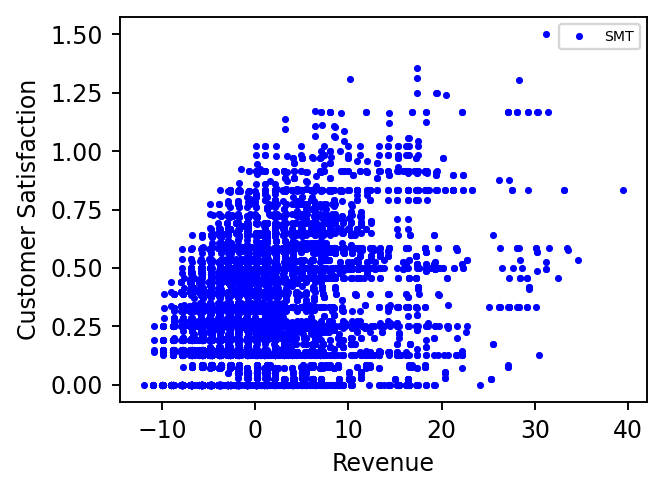

In [11]:
start_time = time.process_time()

s = Solver()
print("EV input:",instance)
print("No. of EVs:",HEIGHT, "\nNo. of time slots:",WIDTH, "\nPorts:", ports)
Rewards = [R_fast, R_slow, W_penalty, D_penalty]

# Constraint --
# Only choose those time slots between the Arrival and Deadline of an EV
for k in range(len(X)):
    Arrival = instance[k][0]
    Deadline = instance[k][1]
    for t in range(WIDTH):
        s.add(If(And(t >= Arrival, t <= Deadline), Or(pickReward(X[k][t]), X[k][t]==0) , X[k][t] == 0))

# Constraint --
# If the energy demand is fulfilled, no other decision should be taken &
# If an EV is denied, no other decision should be taken
for k in range(len(X)):
    total = 0
    Arrival = instance[k][0]
    Deadline = instance[k][1]
    E_demand = instance[k][2]
    for t in range(WIDTH):
        if (t == Arrival):
            s.add(pickReward(X[k][t]))
            
        elif(t>Arrival and t<=Deadline):
            total = total + If(X[k][t-1] == R_fast, R_fast, 0) + If(X[k][t-1] == R_slow, R_slow, 0)
            
#             Constraint --
#             If previous time slot is already 99 + If energy demand is fulfilled + If 'Denied' is chosen
#             make the current time slot 99
            
            s.add(If(Or(X[k][t-1] == 0, total >= E_demand, X[k][t-1] == D_penalty),
                 X[k][t] == 0, 
                 pickReward(X[k][t])))

# Constraint --
# Limit the number of ports accessible at a time slot to 'ports'
for t in range(WIDTH):
    total = 0
    for k in range(HEIGHT):
        total = total + If(X[k][t] == R_fast, 1, 0) + If(X[k][t] == R_slow, 1, 0)
    s.add(total <= ports)
    

# # Constraint --
# # Restrict the 'Profit'
# GridPrice_table = []
# Selling_Prices = []
# for t in range(WIDTH):
#     Load = 0
#     GP_at_t = 0
#     for k in range(HEIGHT):
#         Load = Load + If(X[k][t] == R_fast, R_fast, 0) + If(X[k][t] == R_slow, R_slow, 0)
    
#     GP_at_t = Z3_GridPrice(Load)
# #     s.add(GP_at_t>3)
#     GridPrice_table.append(GP_at_t)
# # print(GridPrice_table)
# # s.add([And(r>1.0, r<7) for r in GridPrice_table])
    
#     slow_charger_price_at_t = float(sp_slow) * GP_at_t
# #     s.add(slow_charger_price_at_t > 4)
#     fast_charger_price_at_t = float(sp_fast) * GP_at_t
    
#     Selling_Prices.append([slow_charger_price_at_t, fast_charger_price_at_t])
    
# profit = 0
# for t in range(WIDTH):
#     for k in range(HEIGHT):
# #         Calculate profit
#         profit = profit + (If(X[k][t] == R_fast, Selling_Prices[t][1]-GridPrice_table[t], 0.0) + 
#                            If(X[k][t] == R_slow, Selling_Prices[t][0]-GridPrice_table[t], 0.0) +
#                            If(X[k][t] == W_penalty, float(W_penalty), 0.0) + 
#                            If(X[k][t] == D_penalty, float(D_penalty), 0.0))

# s.add(profit > 10)
# # print("Grid Price table:", GridPrice_table)

# # Constraint --
# # Restrict the Customer Satisfaction
# totalCS = 0
# for k in range(HEIGHT):
#     Arrival = instance[k][0]
#     Deadline = instance[k][1]
#     E_demand = instance[k][2]
    
# #     Product 1
#     total = 0
#     AllowedTime = float(Deadline - Arrival + 1)
#     for t in range(WIDTH):
#         total = total + If(Or(X[k][t] == R_fast, X[k][t] == R_slow, X[k][t] == W_penalty), 1, 0)
# #     s.add(total == 7)
#     product1 = 1 - ToReal(total)/AllowedTime
# #     s.add(product1==float(0.2))
    
# #     Product 2
#     total = 0
#     for t in range(WIDTH):
#         total = total + If(X[k][t] == R_fast, R_fast, 0) + If(X[k][t] == R_slow, R_slow, 0)
# #     s.add(total == 200)
#     product2 = If(total > E_demand, float(1), ToReal(total)/float(E_demand))
# #     s.add(And(product2>0.4, product2<=0.5))
# #     s.add(And(product1*product2 > 0, product1*product2 <= 0.1))
        
# #     Product 3
# #     Expected price
#     c1 = E_demand
#     c2 = AllowedTime
#     expectedAllocation = expectedSlots(c1, c2)
#     f_chargers = expectedAllocation[0] # No. of expected fast chargers
#     s_chargers = expectedAllocation[1] # No. of expected slow chargers
    
#     gridPrice_atArrival = GridPrice_table[Arrival]
#     expectedSellingPrice = (f_chargers * sp_fast + s_chargers * sp_slow) * gridPrice_atArrival
#     #gridPrice_atArrival
#     s.add(expectedSellingPrice > 0)
    
# #     Actual price
#     actualSellingPrice = 0
#     for t in range(WIDTH):
#         actualSellingPrice = actualSellingPrice + (
#             If(X[k][t] == R_fast, sp_fast * GridPrice_table[t], 0) + 
#             If(X[k][t] == R_slow, sp_slow * GridPrice_table[t], 0)
            
# #             If(X[k][t] == R_fast, sp_fast * GridPrice_table[t], 0) + 
# #             If(X[k][t] == R_slow, sp_slow * GridPrice_table[t], 0)
#         )
# #         print(actualSellingPrice)
        
#     Pa_by_Pe = actualSellingPrice / expectedSellingPrice
#     product3 = Pa_by_Pe + beta
    
#     indiv_CS = (product1 * product2) / product3
#     totalCS = totalCS + indiv_CS
    
# s.add(totalCS > 0.2)
# s.add(Or(And(profit>0, totalCS>0.4),And(profit > 10, totalCS > 0.2)))

# s.add(X[0][0] == F)
# s.add(X[0][1] == W)

# s.add(X[1][1] == F)
# s.add(X[1][2] == S)
# s.add(X[1][3] == S)

# s.add(X[2][1] == S)
# s.add(X[2][2] == S)
# s.add(X[2][3] == S)

# s.add(X[3][2] == W)
# s.add(X[3][3] == S)
# s.add(X[3][4] == F)

# # -----------Solutions section------------
    
results = get_models()
print("Total Solutions:",len(results))

fileName = "comp_onlyProfit_SMT"

write_to_file(results, fileName+".csv")

plot_graph(fileName)

print("Total time taken:", (time.process_time()-start_time)/60,"mins")
